In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
root_path = os.path.abspath('./..')
sys.path.insert(0, root_path )

import itertools
import functools
from tqdm import tqdm

import pandas as pd
import numpy as np
import sklearn
import sklearn.linear_model
import sklearn.cluster
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns

import hiddensc
from hiddensc import utils, files, vis

import scanpy as sc
import scvi
import anndata

utils.set_random_seed(utils.RANDOM_SEED)
utils.print_module_versions([sc, anndata, scvi, hiddensc])
vis.visual_settings()

Global seed set to 0


Random seed set to 42
scanpy              : 1.9.3
anndata             : 0.8.0
scvi                : 0.20.3
hiddensc            : beta_25.03.23


# Load results

In [3]:
EXP_IDS = ['49', '100', '154', '211', '271', '335', '403', '475',
           '552', '633', '721', '814', '915', '1023', '1140', '1267', '1404', '1555']

performance_dfs ={}
degenes_arr = {}
degenes_dfs = {}
batch_arr = {}
perturbed_arr = {}
pred_dfs = {}

for exp_id in EXP_IDS:
    exp_id = int(exp_id)
    exp_name = f'naiveB_1900_memoryB_{exp_id:d}'
    at_results_dir = functools.partial(os.path.join, root_path, files.RESULT_DIR, exp_name)
    fname = at_results_dir('predictions.csv')
    if os.path.exists(fname):
        batch_arr[exp_name], perturbed_arr[exp_name], pred_df = files.load_predictions(at_results_dir())
        pred_dfs[exp_name] = pred_df
    fname = at_results_dir('classification_stats.csv')
    if os.path.exists(fname):
        performance_dfs[exp_name] = pd.read_csv(fname)
    fname = at_results_dir('de_genes.csv')
    if os.path.exists(fname):
        degenes_dfs[exp_name] = pd.read_csv(fname)
        degenes_arr[exp_name] = files.load_npz(fname.replace('.csv','.npz'))
    
all_performance_df = pd.concat(list(performance_dfs.values()))
vis.peek_df(all_performance_df)
all_degenes_df = pd.concat(list(degenes_dfs.values()))
vis.peek_df(all_degenes_df)

DF shape: (270, 8)
Columns: ['Dataset', 'DimReduction', 'PredictionMethod', 'AUCROC', 'AP', 'Recall', 'Precision', 'F1']


,Dataset,DimReduction,PredictionMethod,AUCROC,AP,Recall,Precision,F1
0,naiveB_1900_memoryB_49,LinearSCVI_10,Logistic,0.955,0.409,1.000,0.127,0.225
1,naiveB_1900_memoryB_49,LinearSCVI_10,SVM,0.932,0.310,1.000,0.086,0.158


DF shape: (288, 9)
Columns: ['Dataset', 'True labels', 'DimReduction', 'PredictionMethod', 'Approach', 'Precision', 'Recall', 'FDR', 'F1']


,Dataset,True labels,DimReduction,PredictionMethod,Approach,Precision,Recall,FDR,F1
0,naiveB_1900_memoryB_49,Naive B/Memory B,NaN,NaN,sample,NaN,0.000,NaN,NaN
1,naiveB_1900_memoryB_49,Naive B/Memory B,LinearSCVI_10,Logistic,LinearSCVI_10_Logistic,0.357,0.714,0.643,0.476


In [9]:
percent_map = dict(zip([  49,  100,  154,  211,  271,  335,  403,  475,  552,  633,  721,
        814,  915, 1023, 1140, 1267, 1404, 1555],
         [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90]))

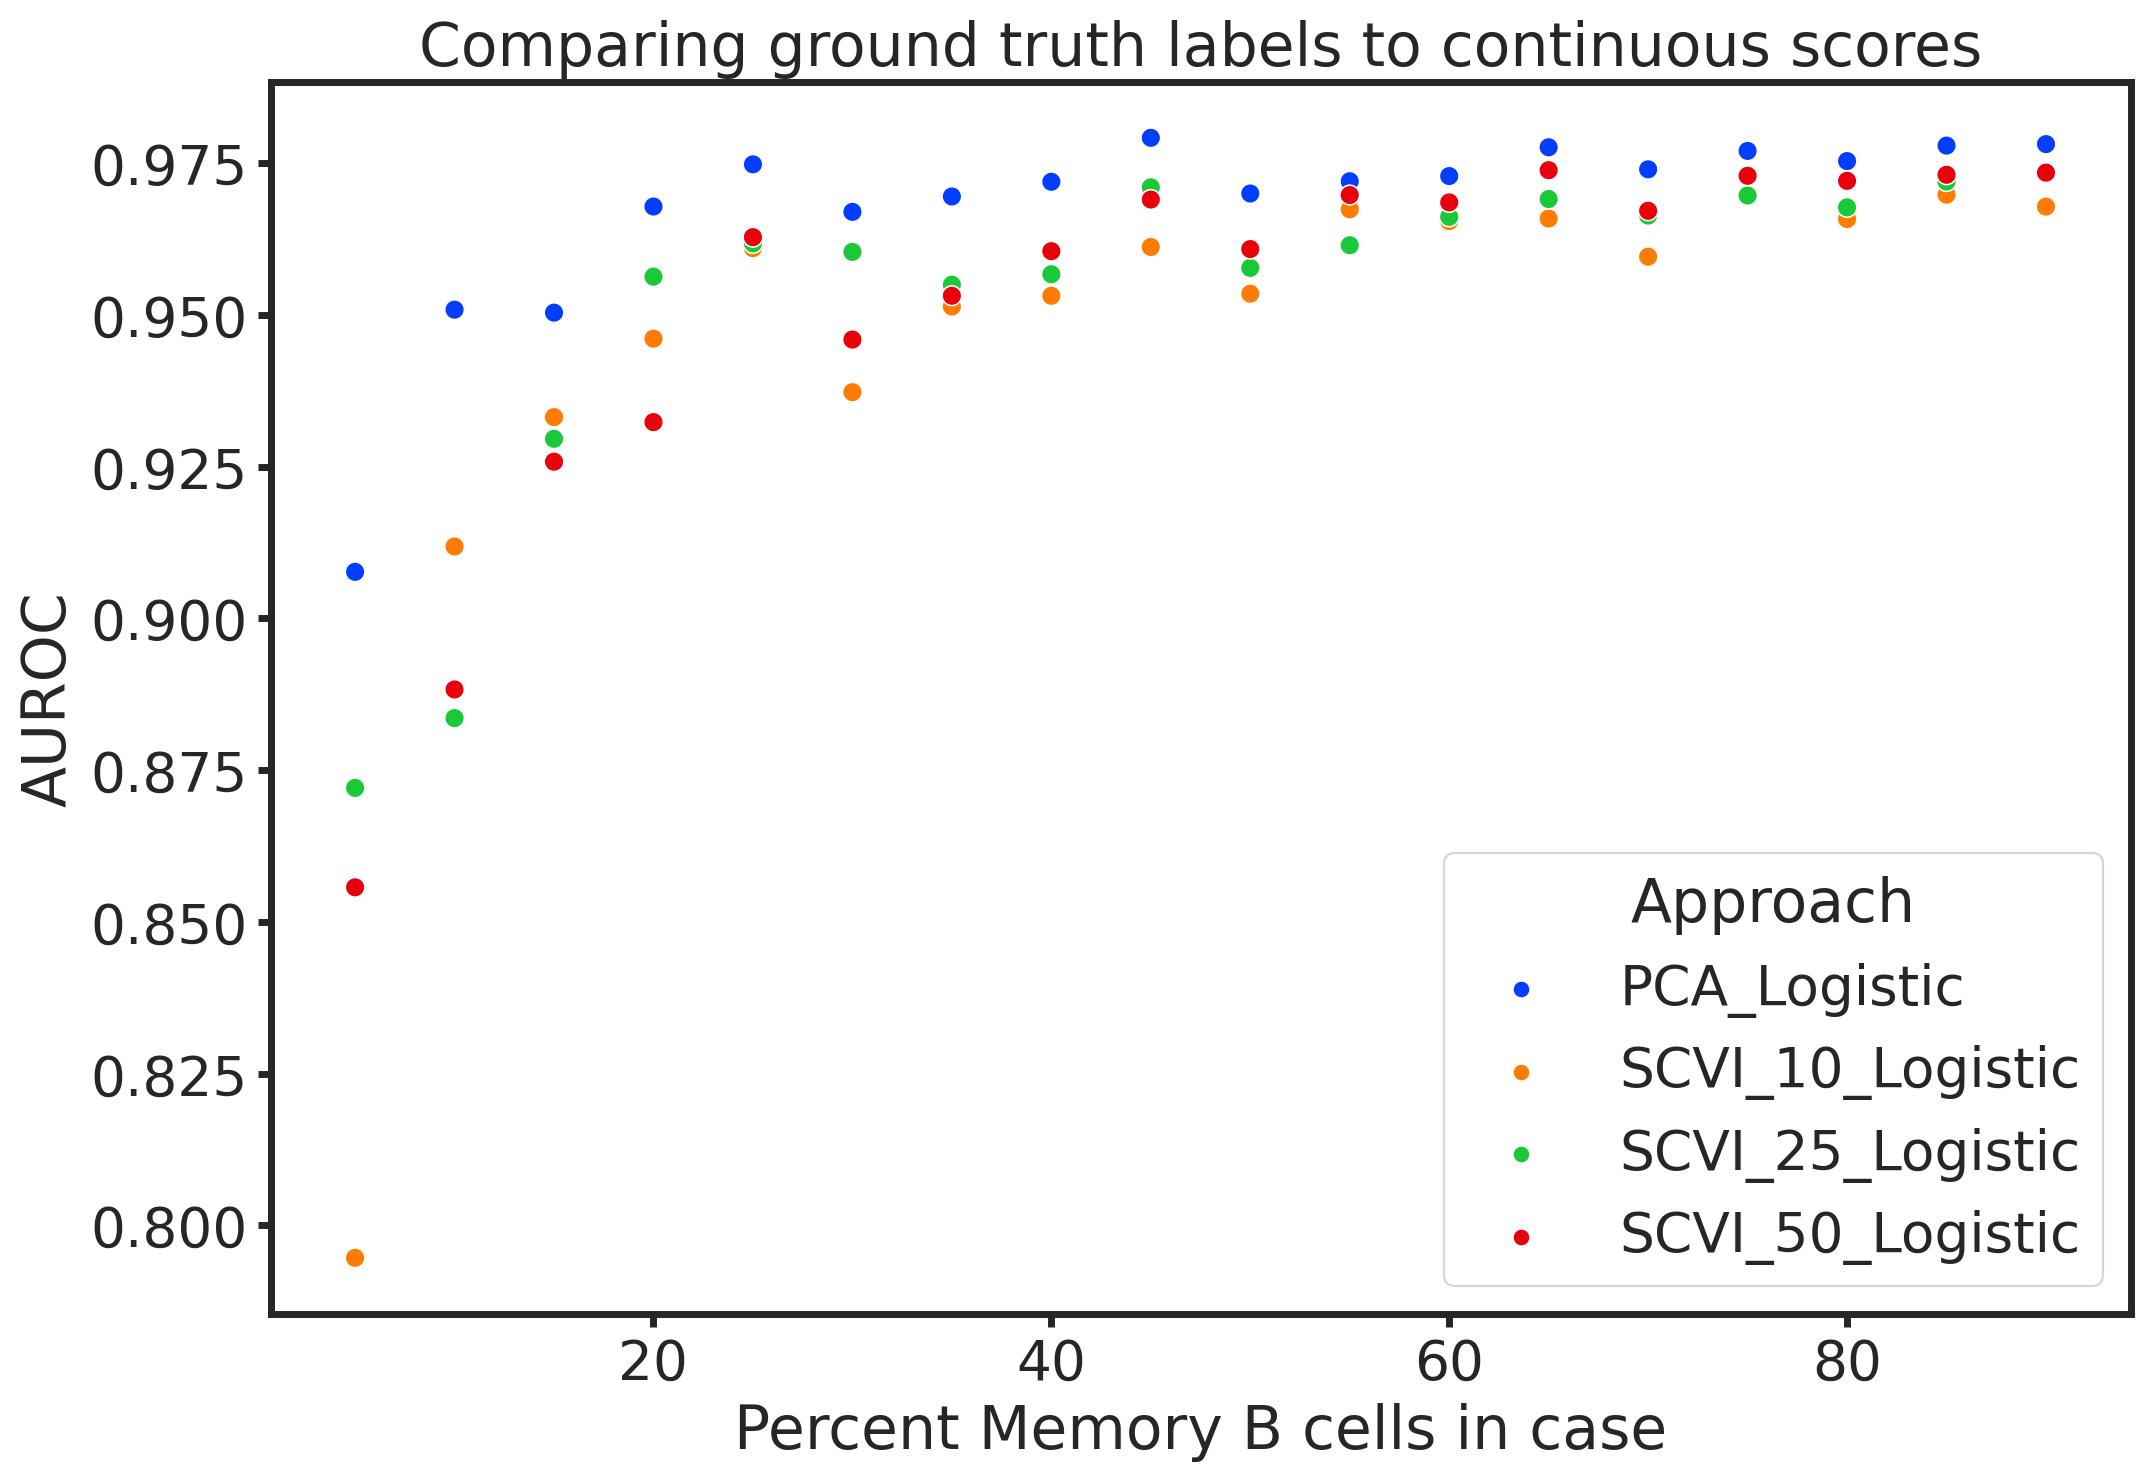

In [13]:
for metric in ['AUCROC']:
    methods = ['PCA_Logistic', 'SCVI_10_Logistic', 'SCVI_25_Logistic', 'SCVI_50_Logistic']
    vis_df = all_performance_df
    vis_df['Num Mem B cells'] = vis_df['Dataset'].apply(lambda x: int(x.split('_')[-1]))
    vis_df['Percent Memory B cells in case'] = vis_df['Num Mem B cells'].apply(lambda x: percent_map[x])
    vis_df['Approach'] = vis_df['DimReduction']+'_'+vis_df['PredictionMethod']
    mask = vis_df['Approach'].isin(list(methods))
    vis_df = vis_df[mask]
    sns.scatterplot(x='Percent Memory B cells in case', y=metric, hue='Approach', data=vis_df, s=50)
    plt.xlabel('Percent Memory B cells in case')
    plt.ylabel('AUROC')
    #plt.ylim([-0.05, 1.05]) 
    plt.title(f'Comparing ground truth labels to continuous scores')
    plt.savefig(f'figures/AUROC_PCA_SCVI.png', dpi=300, transparent=True, bbox_inches='tight')
    plt.savefig(f'figures/AUROC_PCA_SCVI.svg', transparent=True, bbox_inches='tight')
    plt.savefig(f'figures/AUROC_PCA_SCVI.pdf', transparent=True, bbox_inches='tight')    
    plt.show()

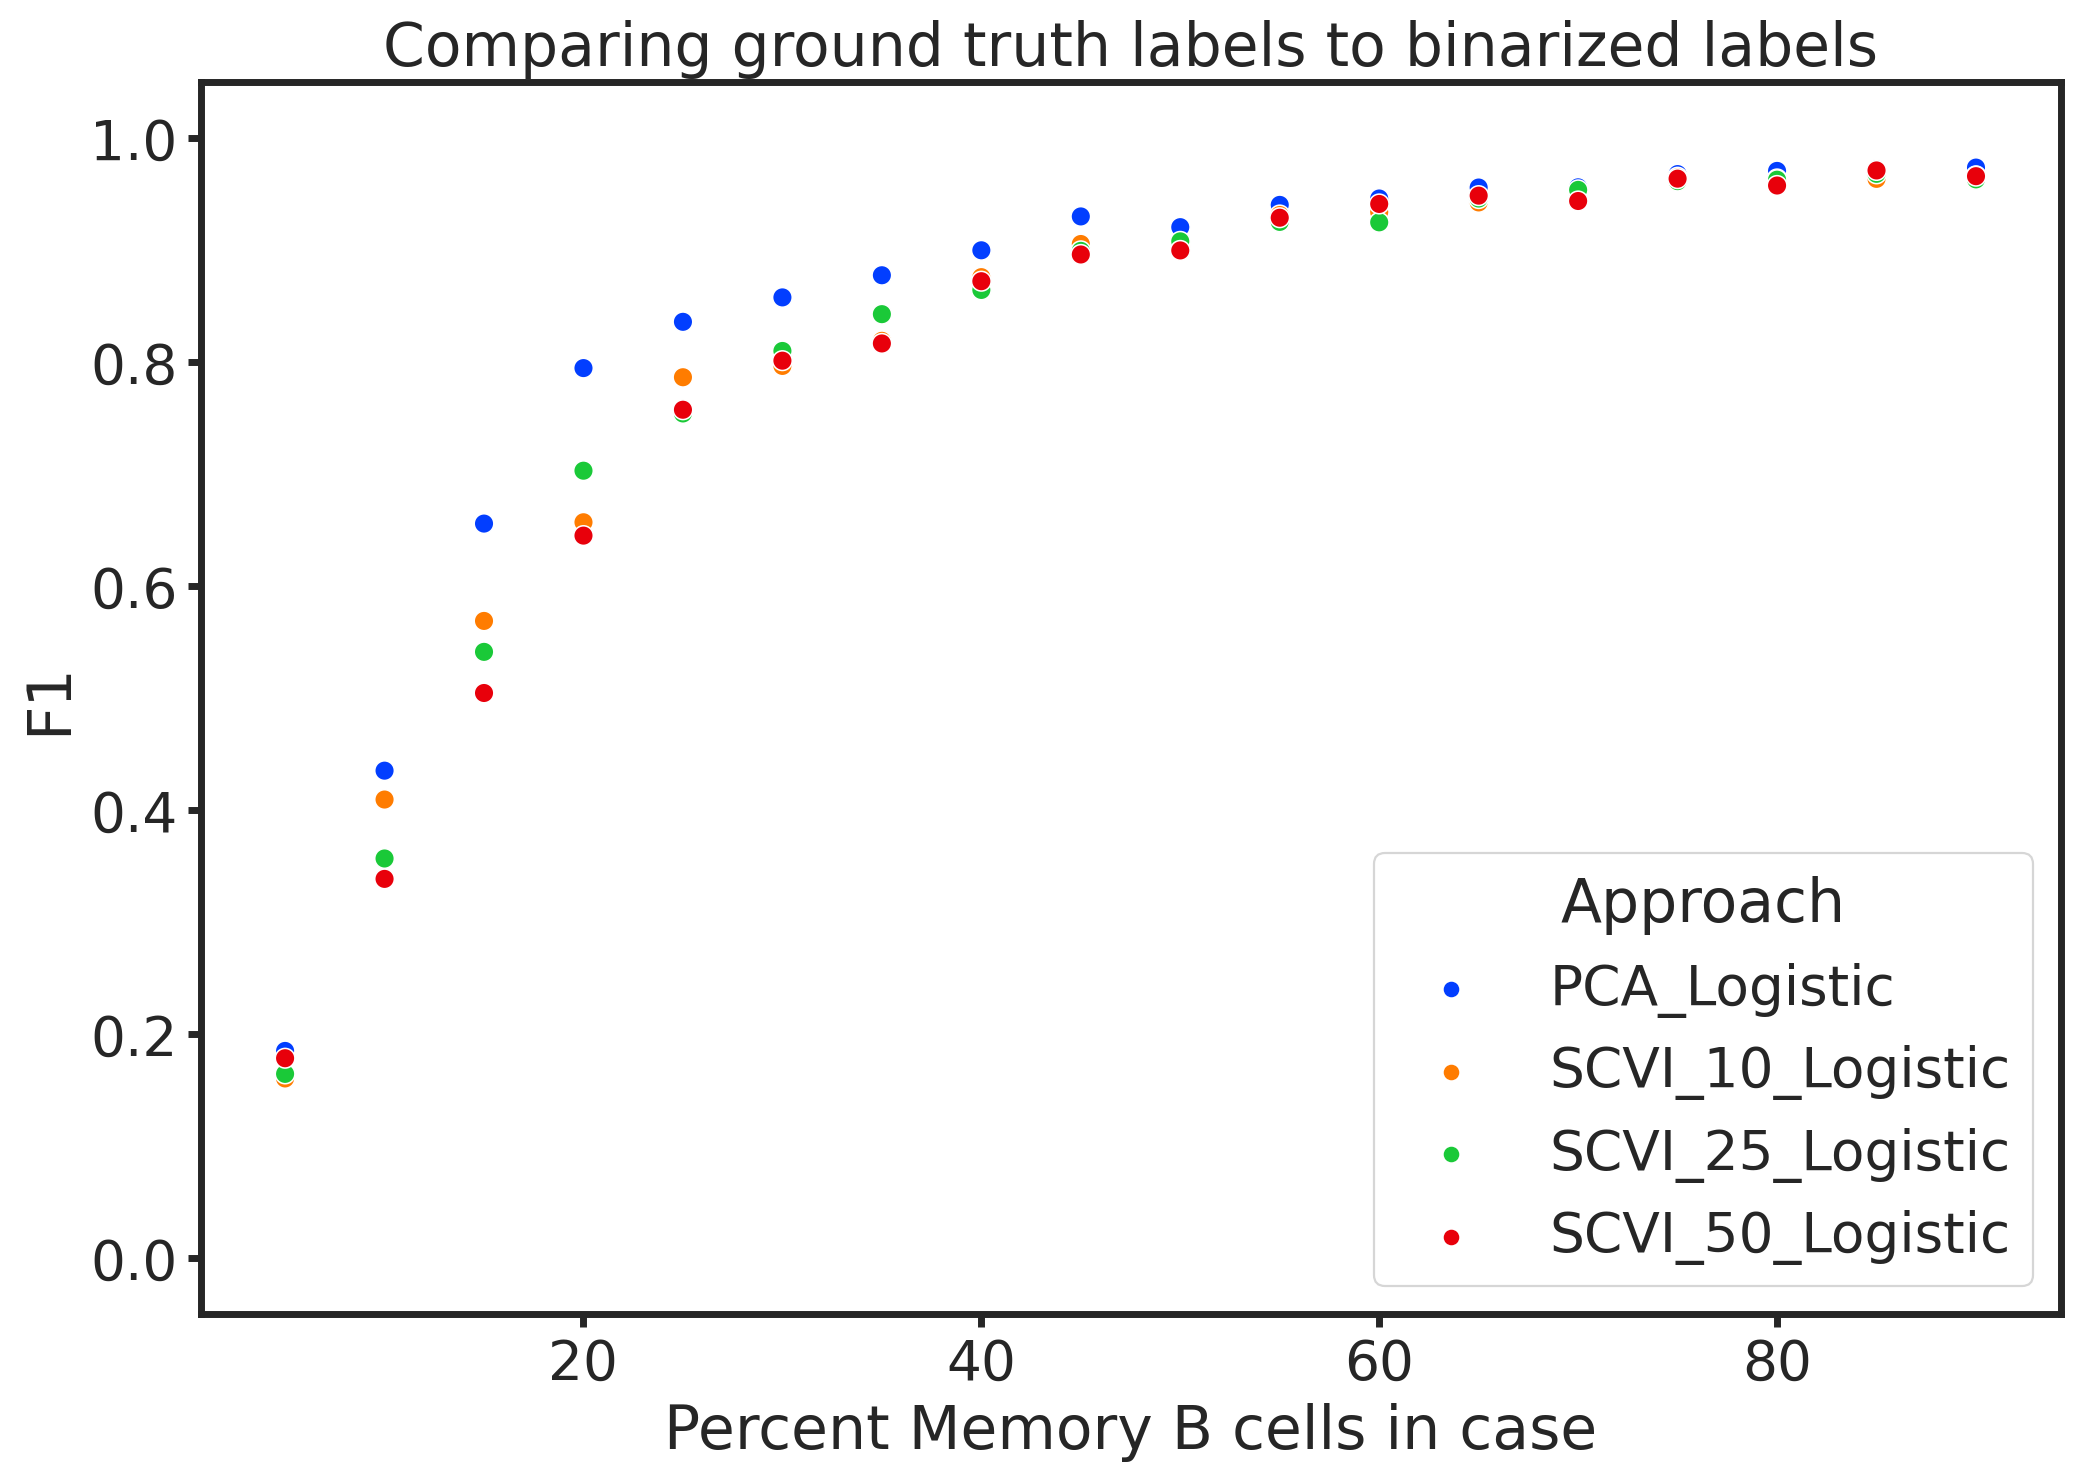

In [14]:
for metric in ['F1']:
    methods = ['PCA_Logistic', 'SCVI_10_Logistic', 'SCVI_25_Logistic', 'SCVI_50_Logistic']
    vis_df = all_performance_df
    vis_df['Num Mem B cells'] = vis_df['Dataset'].apply(lambda x: int(x.split('_')[-1]))
    vis_df['Percent Memory B cells in case'] = vis_df['Num Mem B cells'].apply(lambda x: percent_map[x])
    vis_df['Approach'] = vis_df['DimReduction']+'_'+vis_df['PredictionMethod']
    mask = vis_df['Approach'].isin(list(methods))
    vis_df = vis_df[mask]
    sns.scatterplot(x='Percent Memory B cells in case', y=metric, hue='Approach', data=vis_df, s=50)
    plt.xlabel('Percent Memory B cells in case')
    plt.ylabel('F1')
    plt.ylim([-0.05, 1.05]) 
    plt.title(f'Comparing ground truth labels to binarized labels')
    plt.savefig(f'figures/F1_PCA_SCVI.png', dpi=300, transparent=True, bbox_inches='tight')
    plt.savefig(f'figures/F1_PCA_SCVI.svg', transparent=True, bbox_inches='tight')
    plt.savefig(f'figures/F1_PCA_SCVI.pdf', transparent=True, bbox_inches='tight')  
    plt.show()

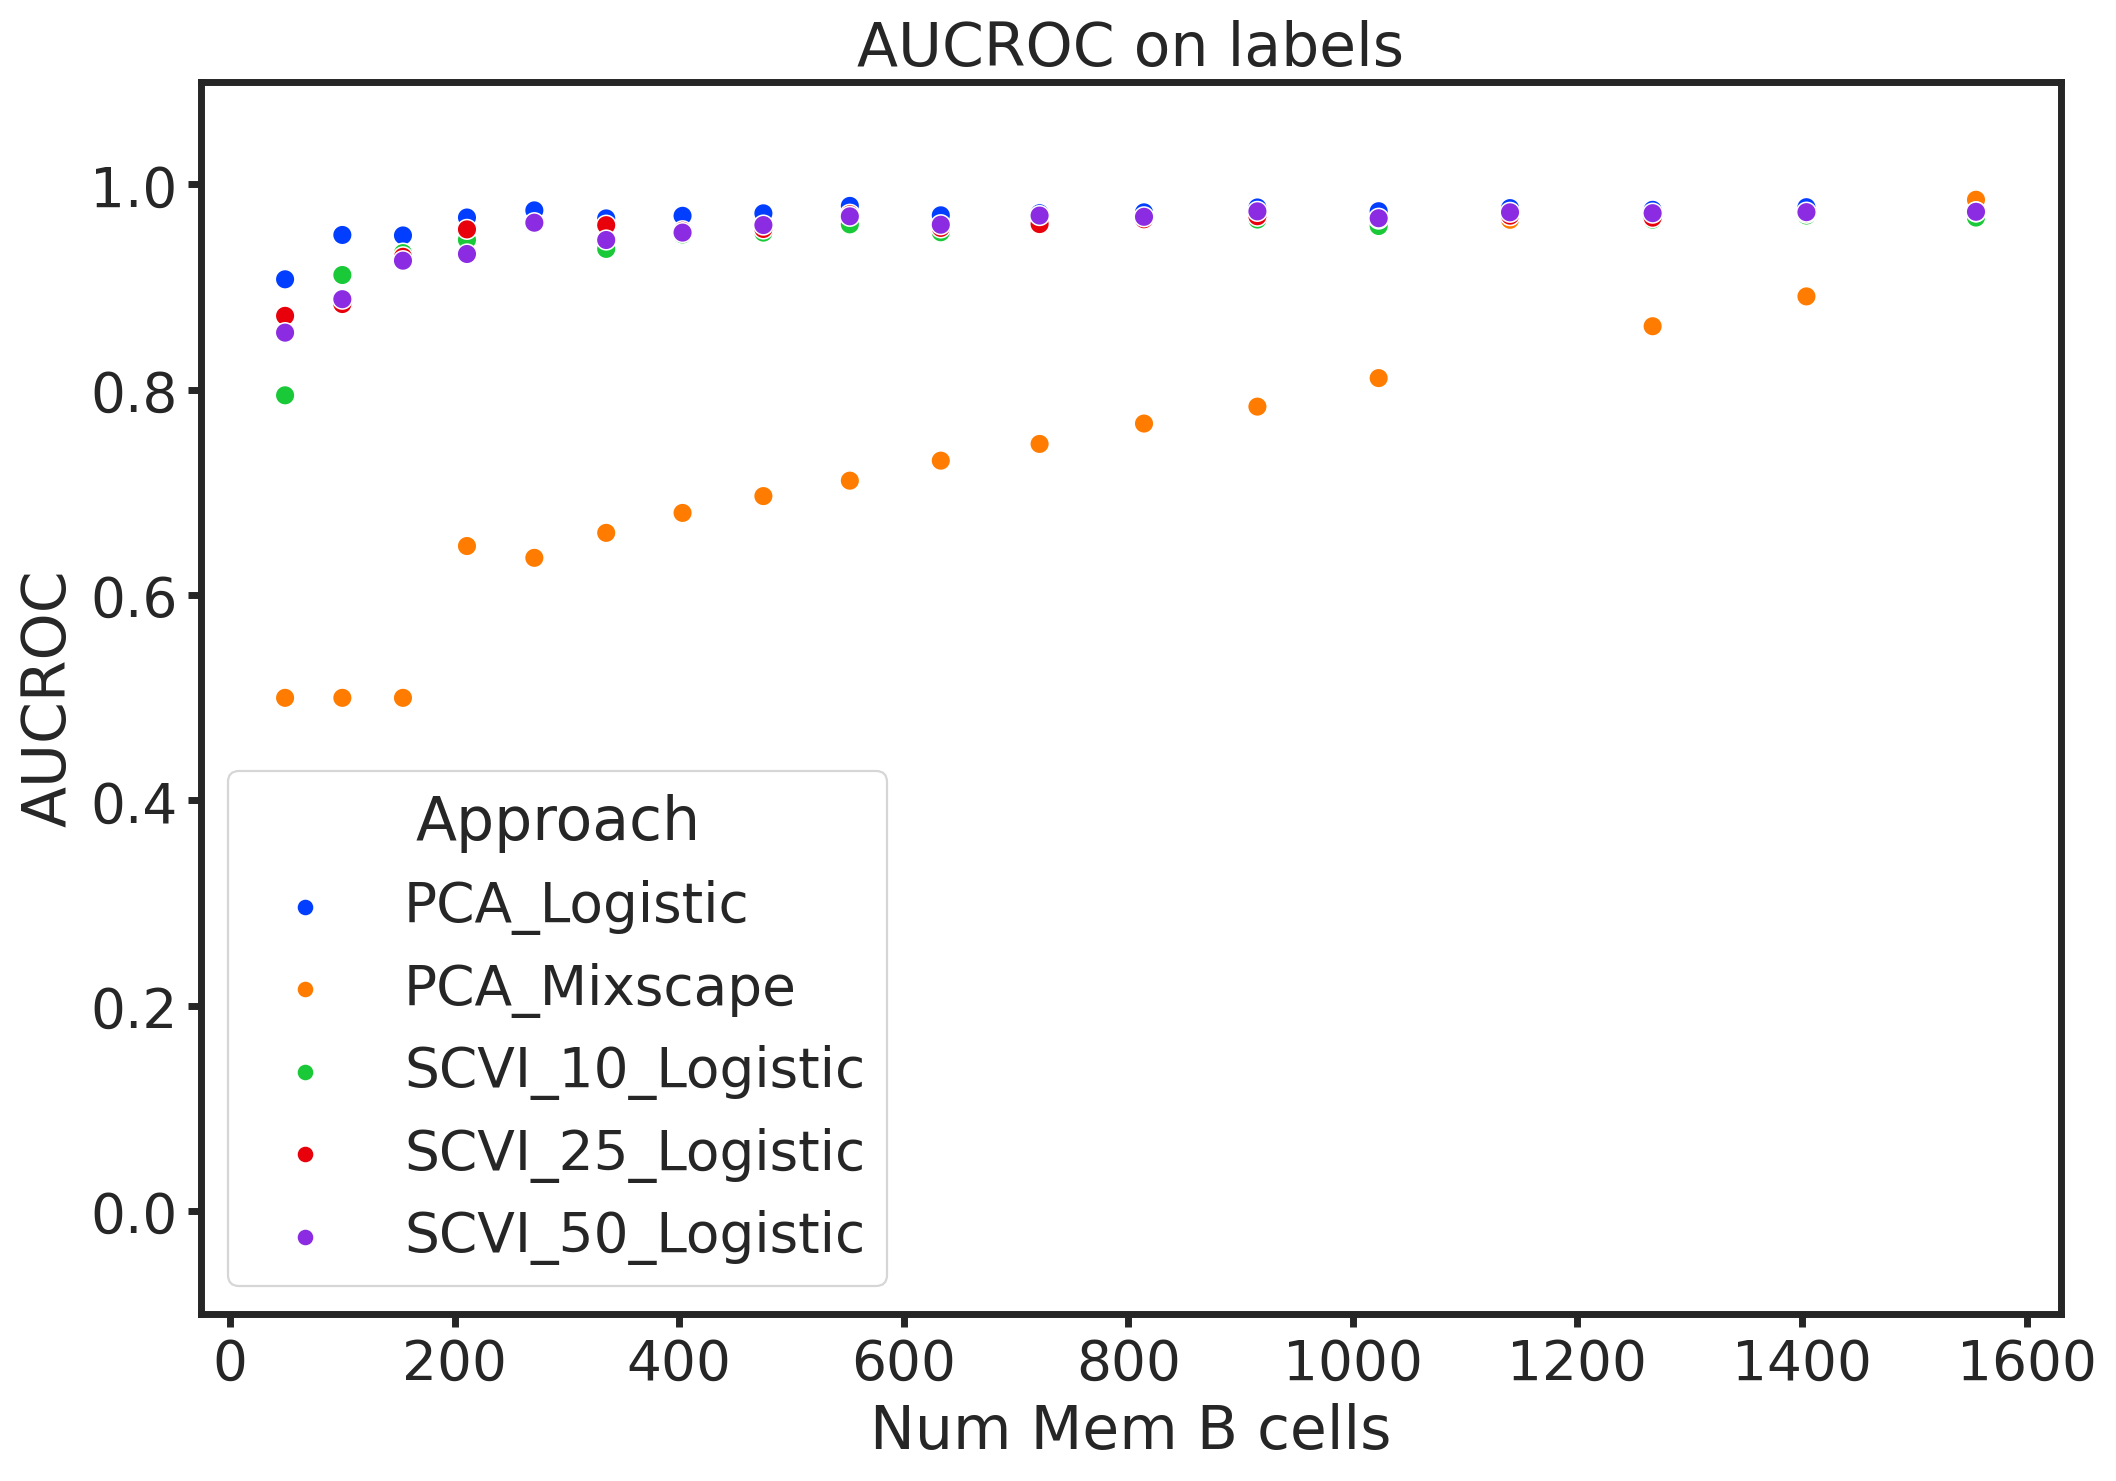

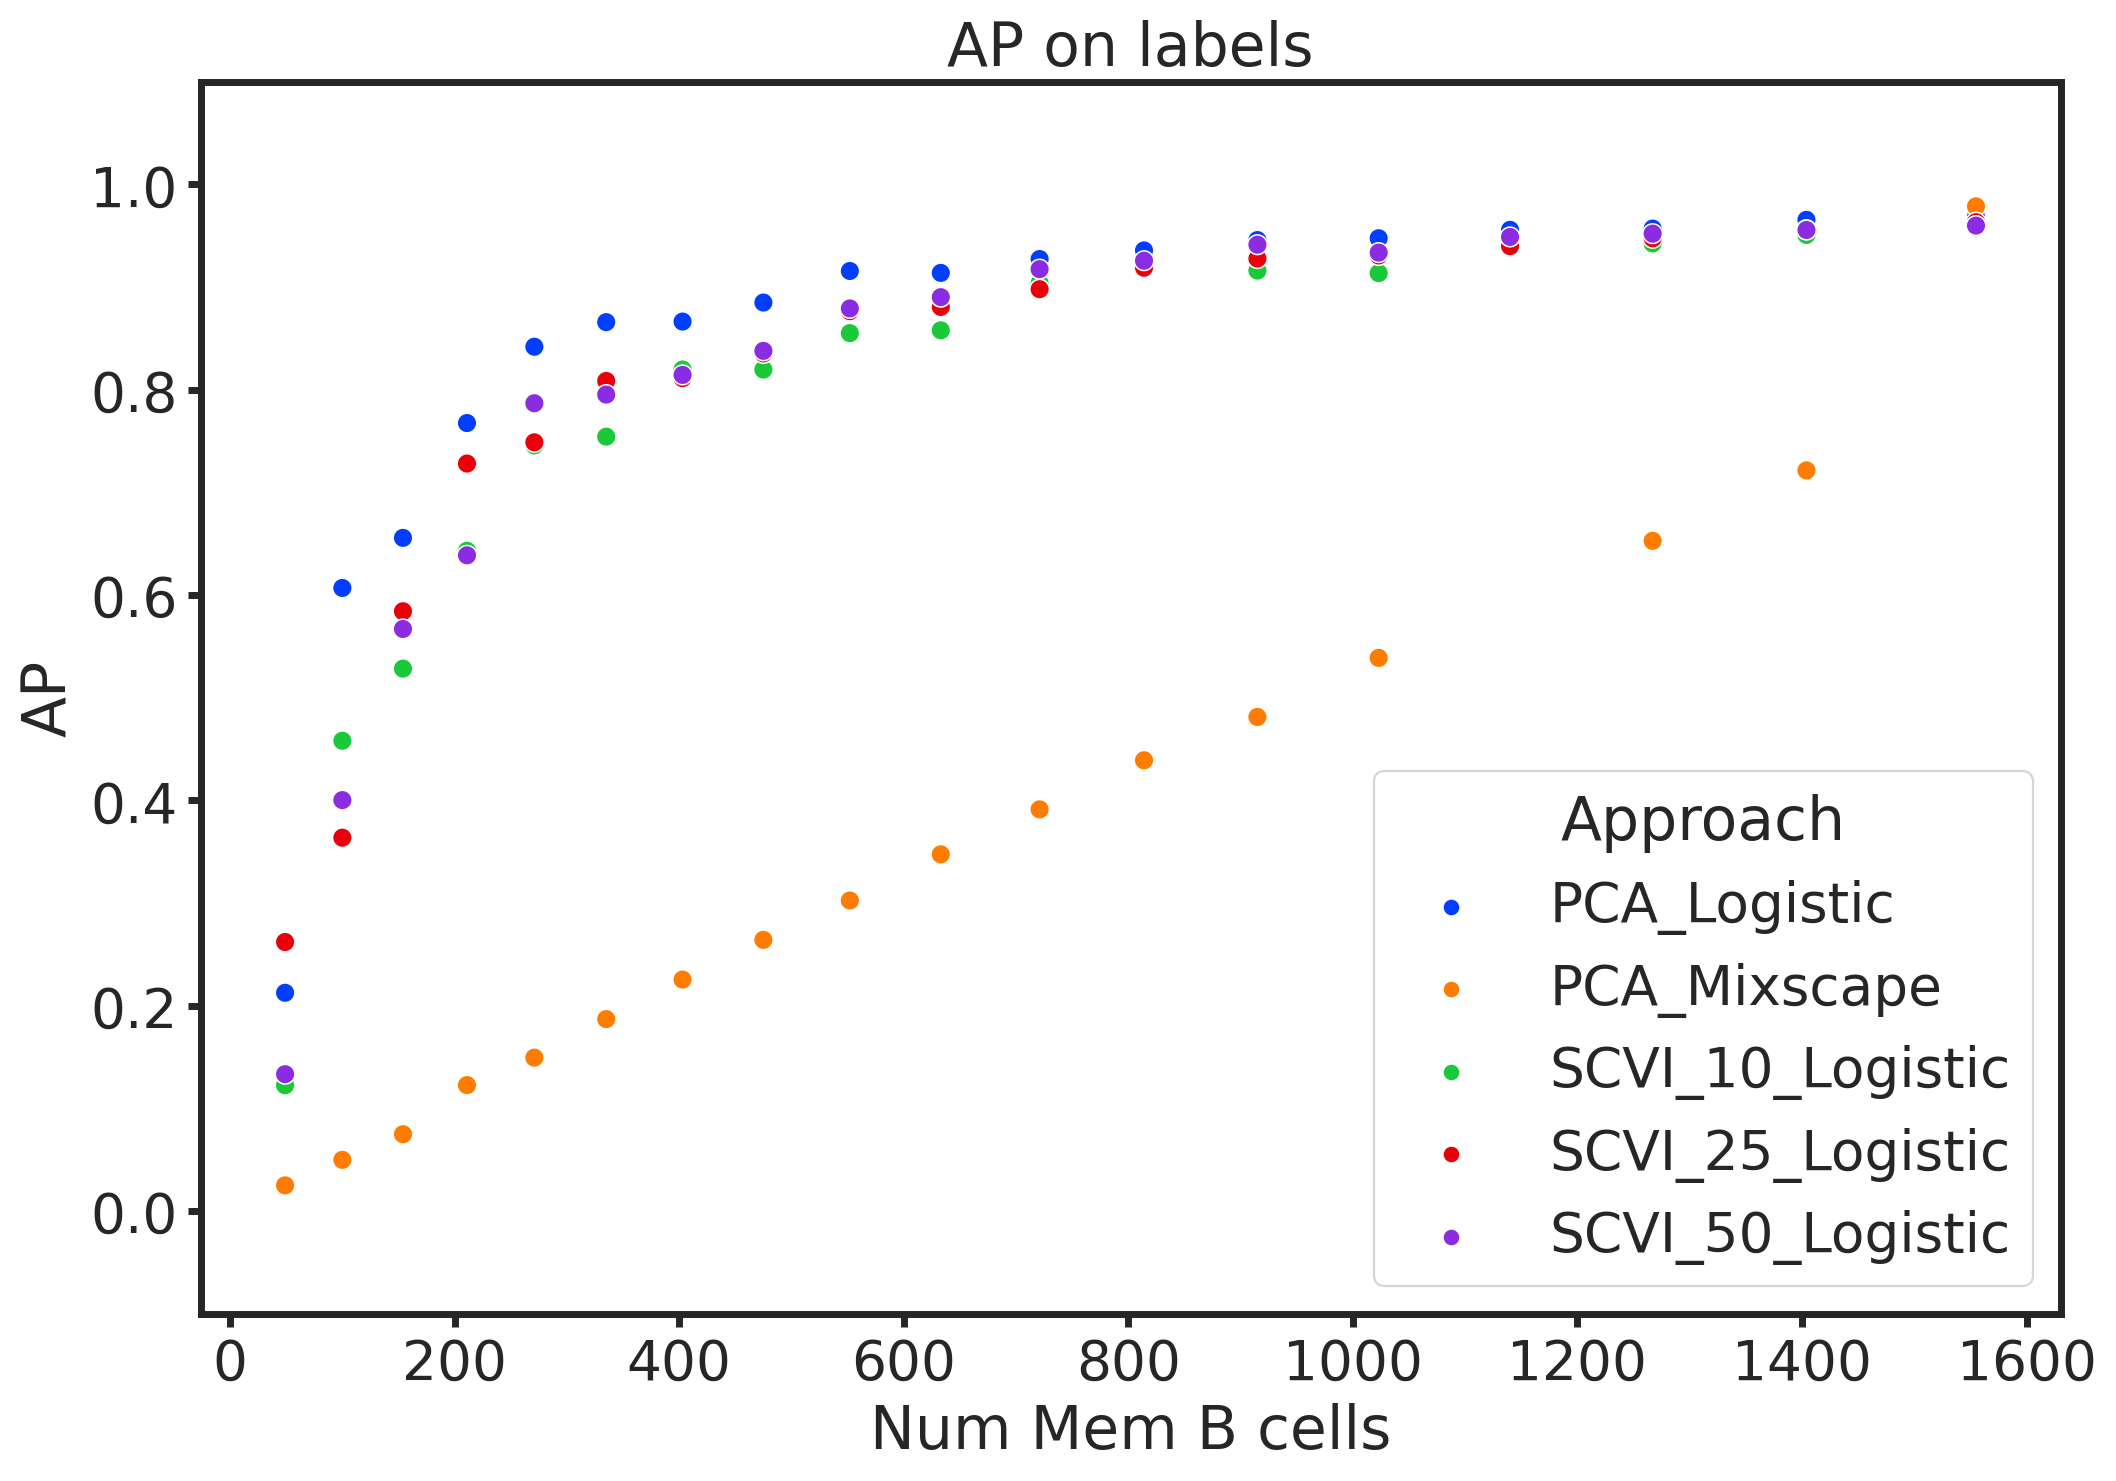

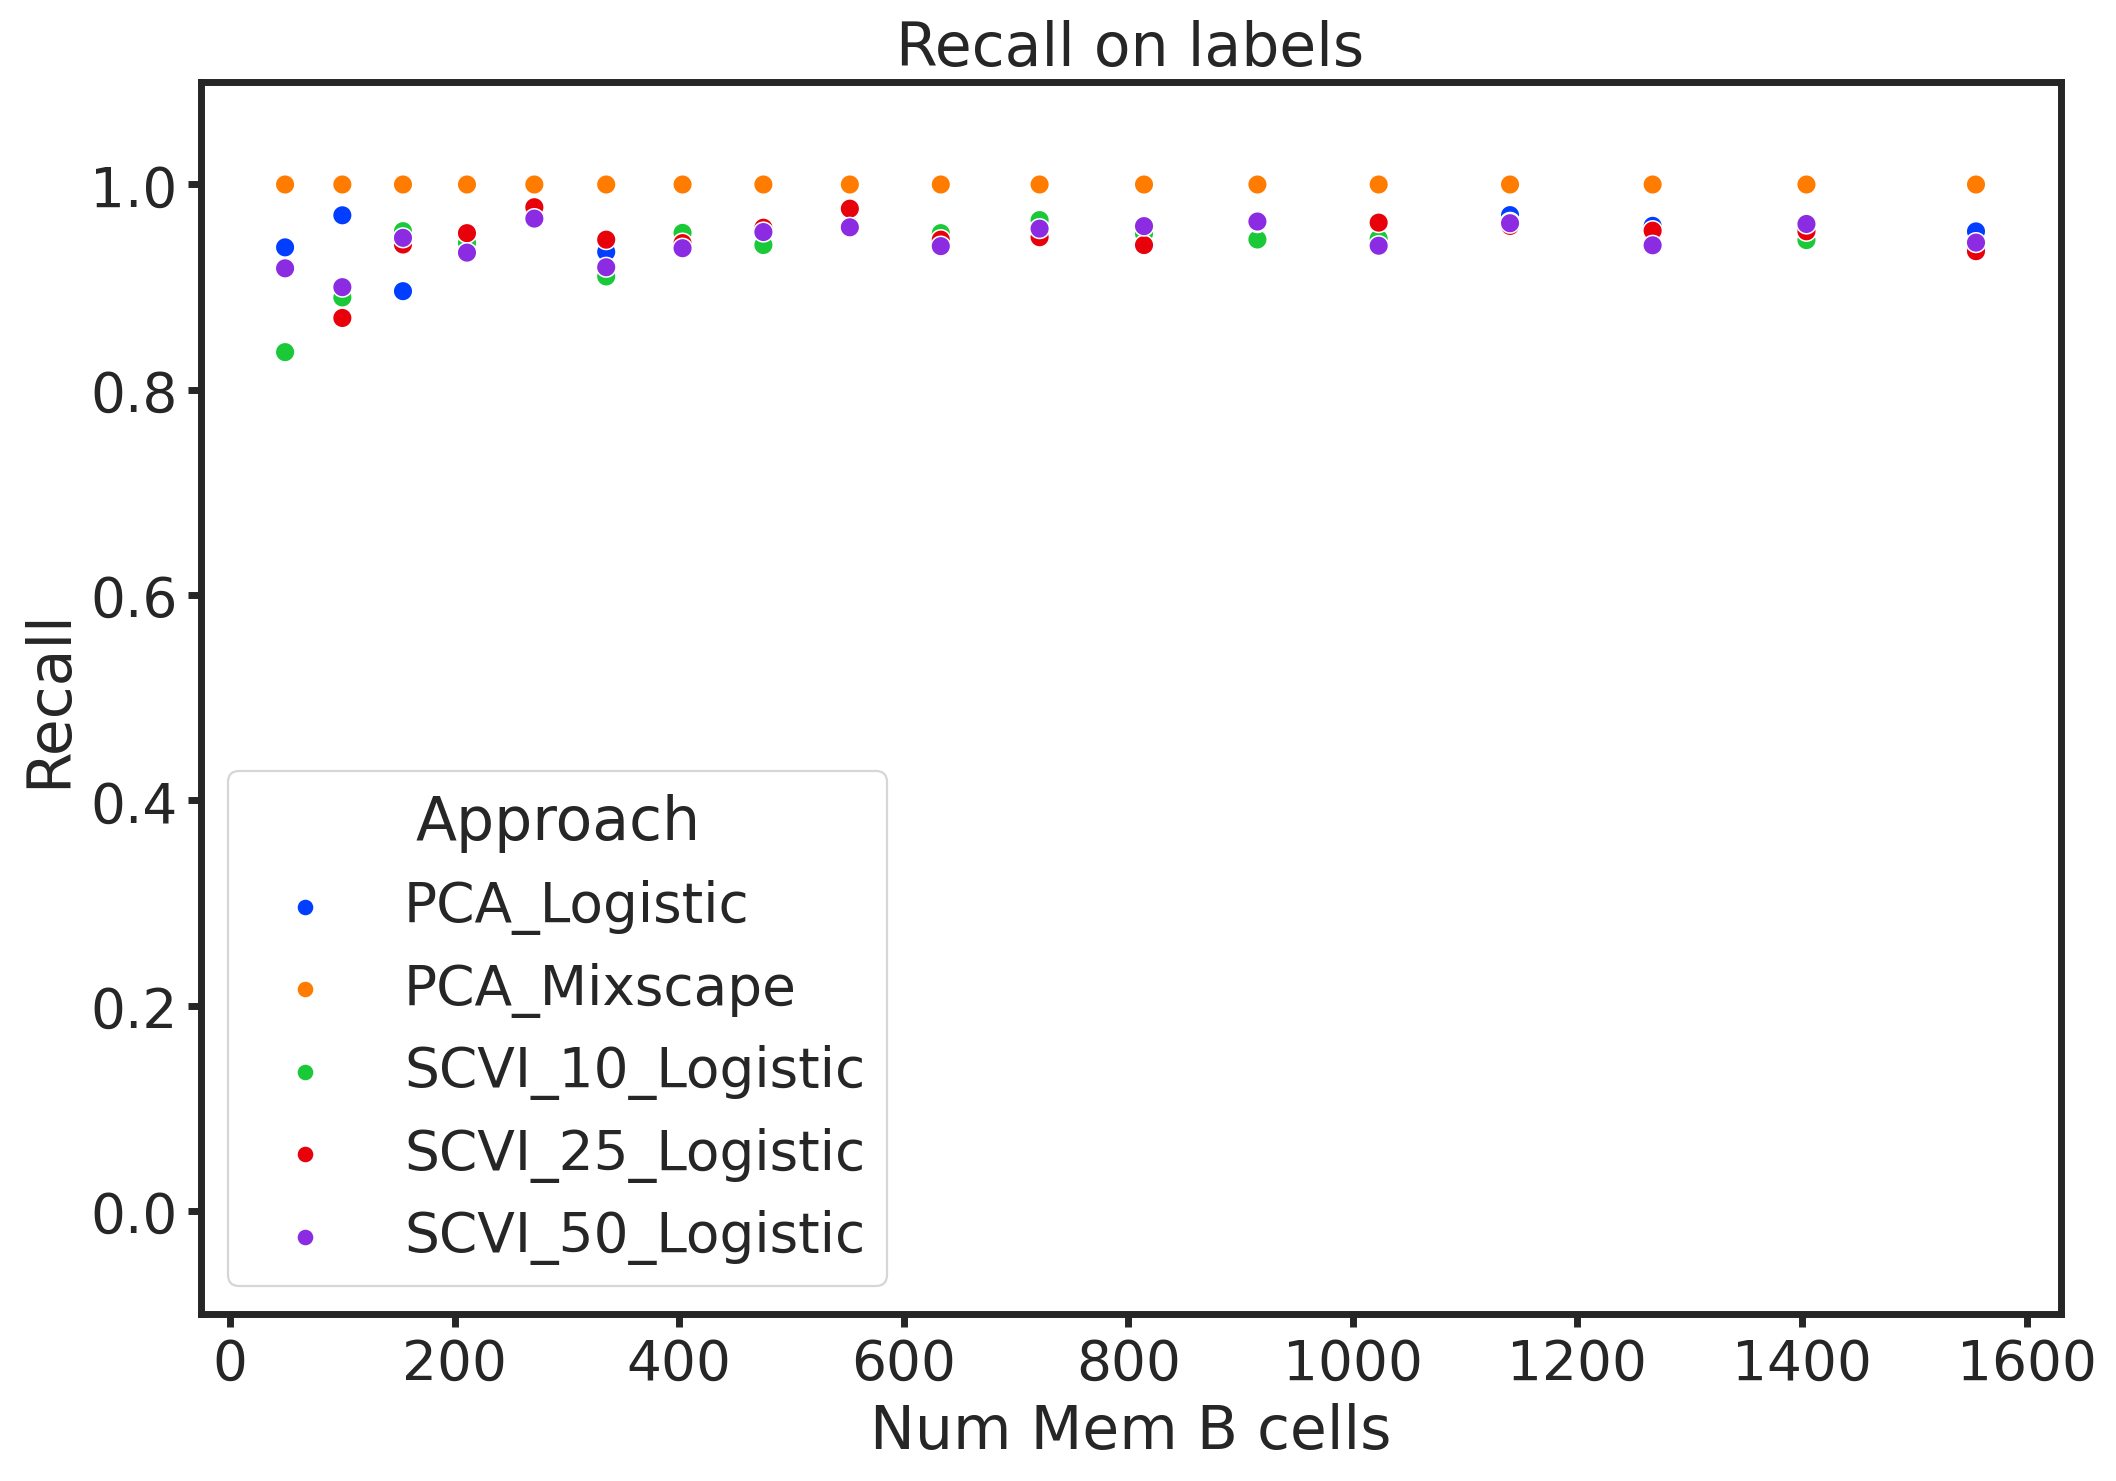

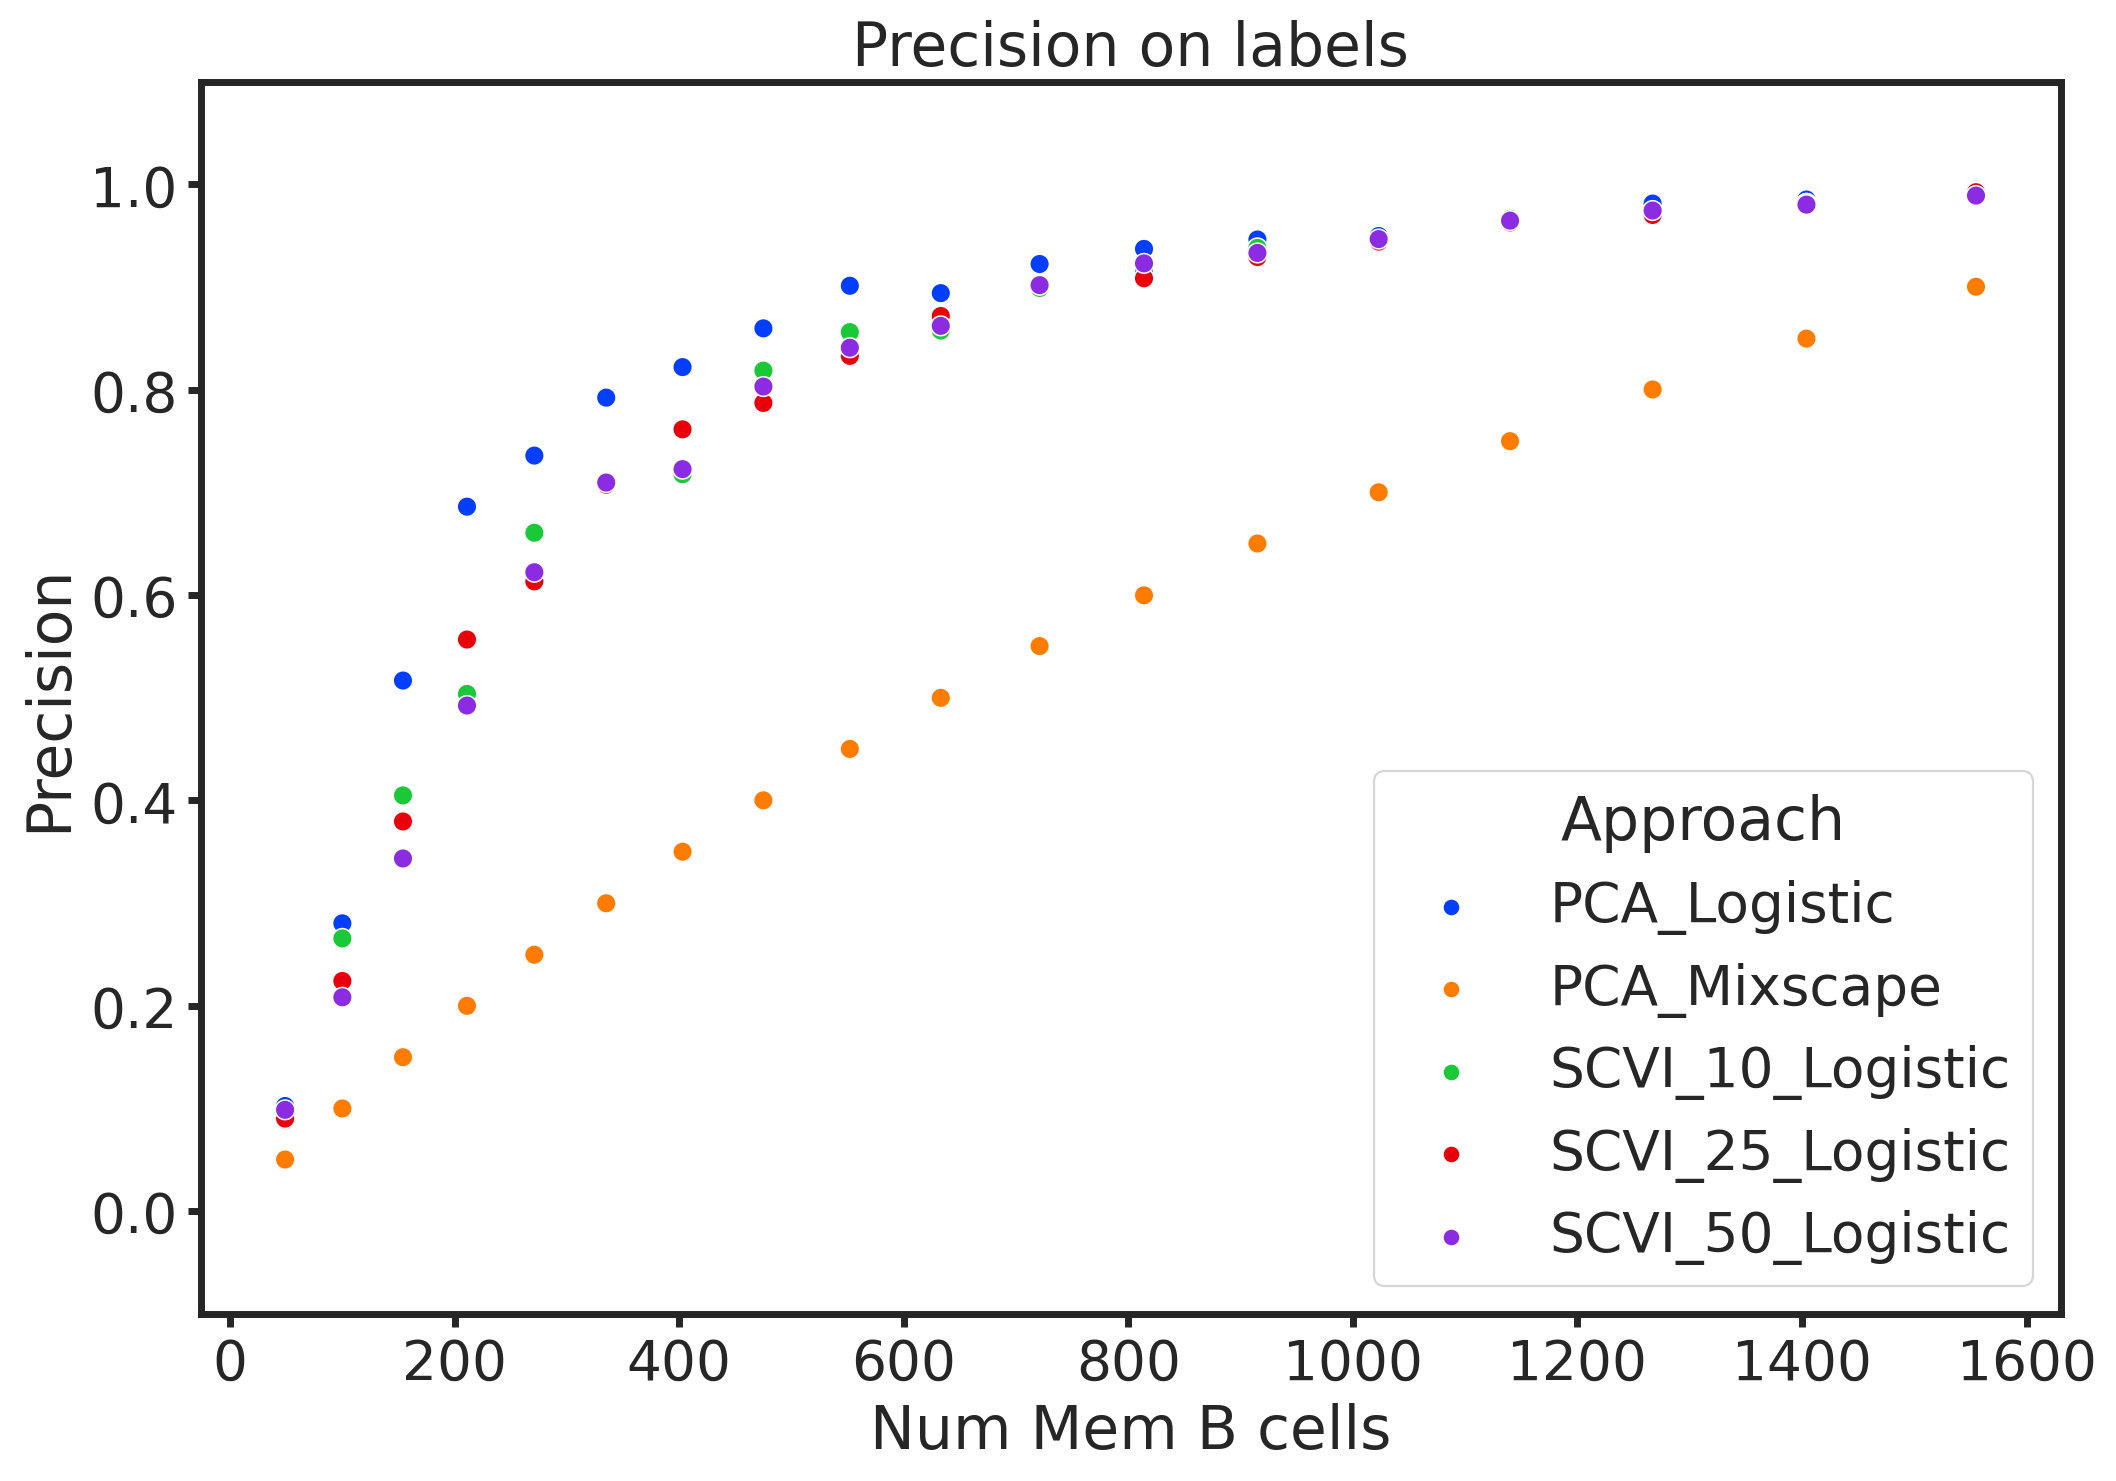

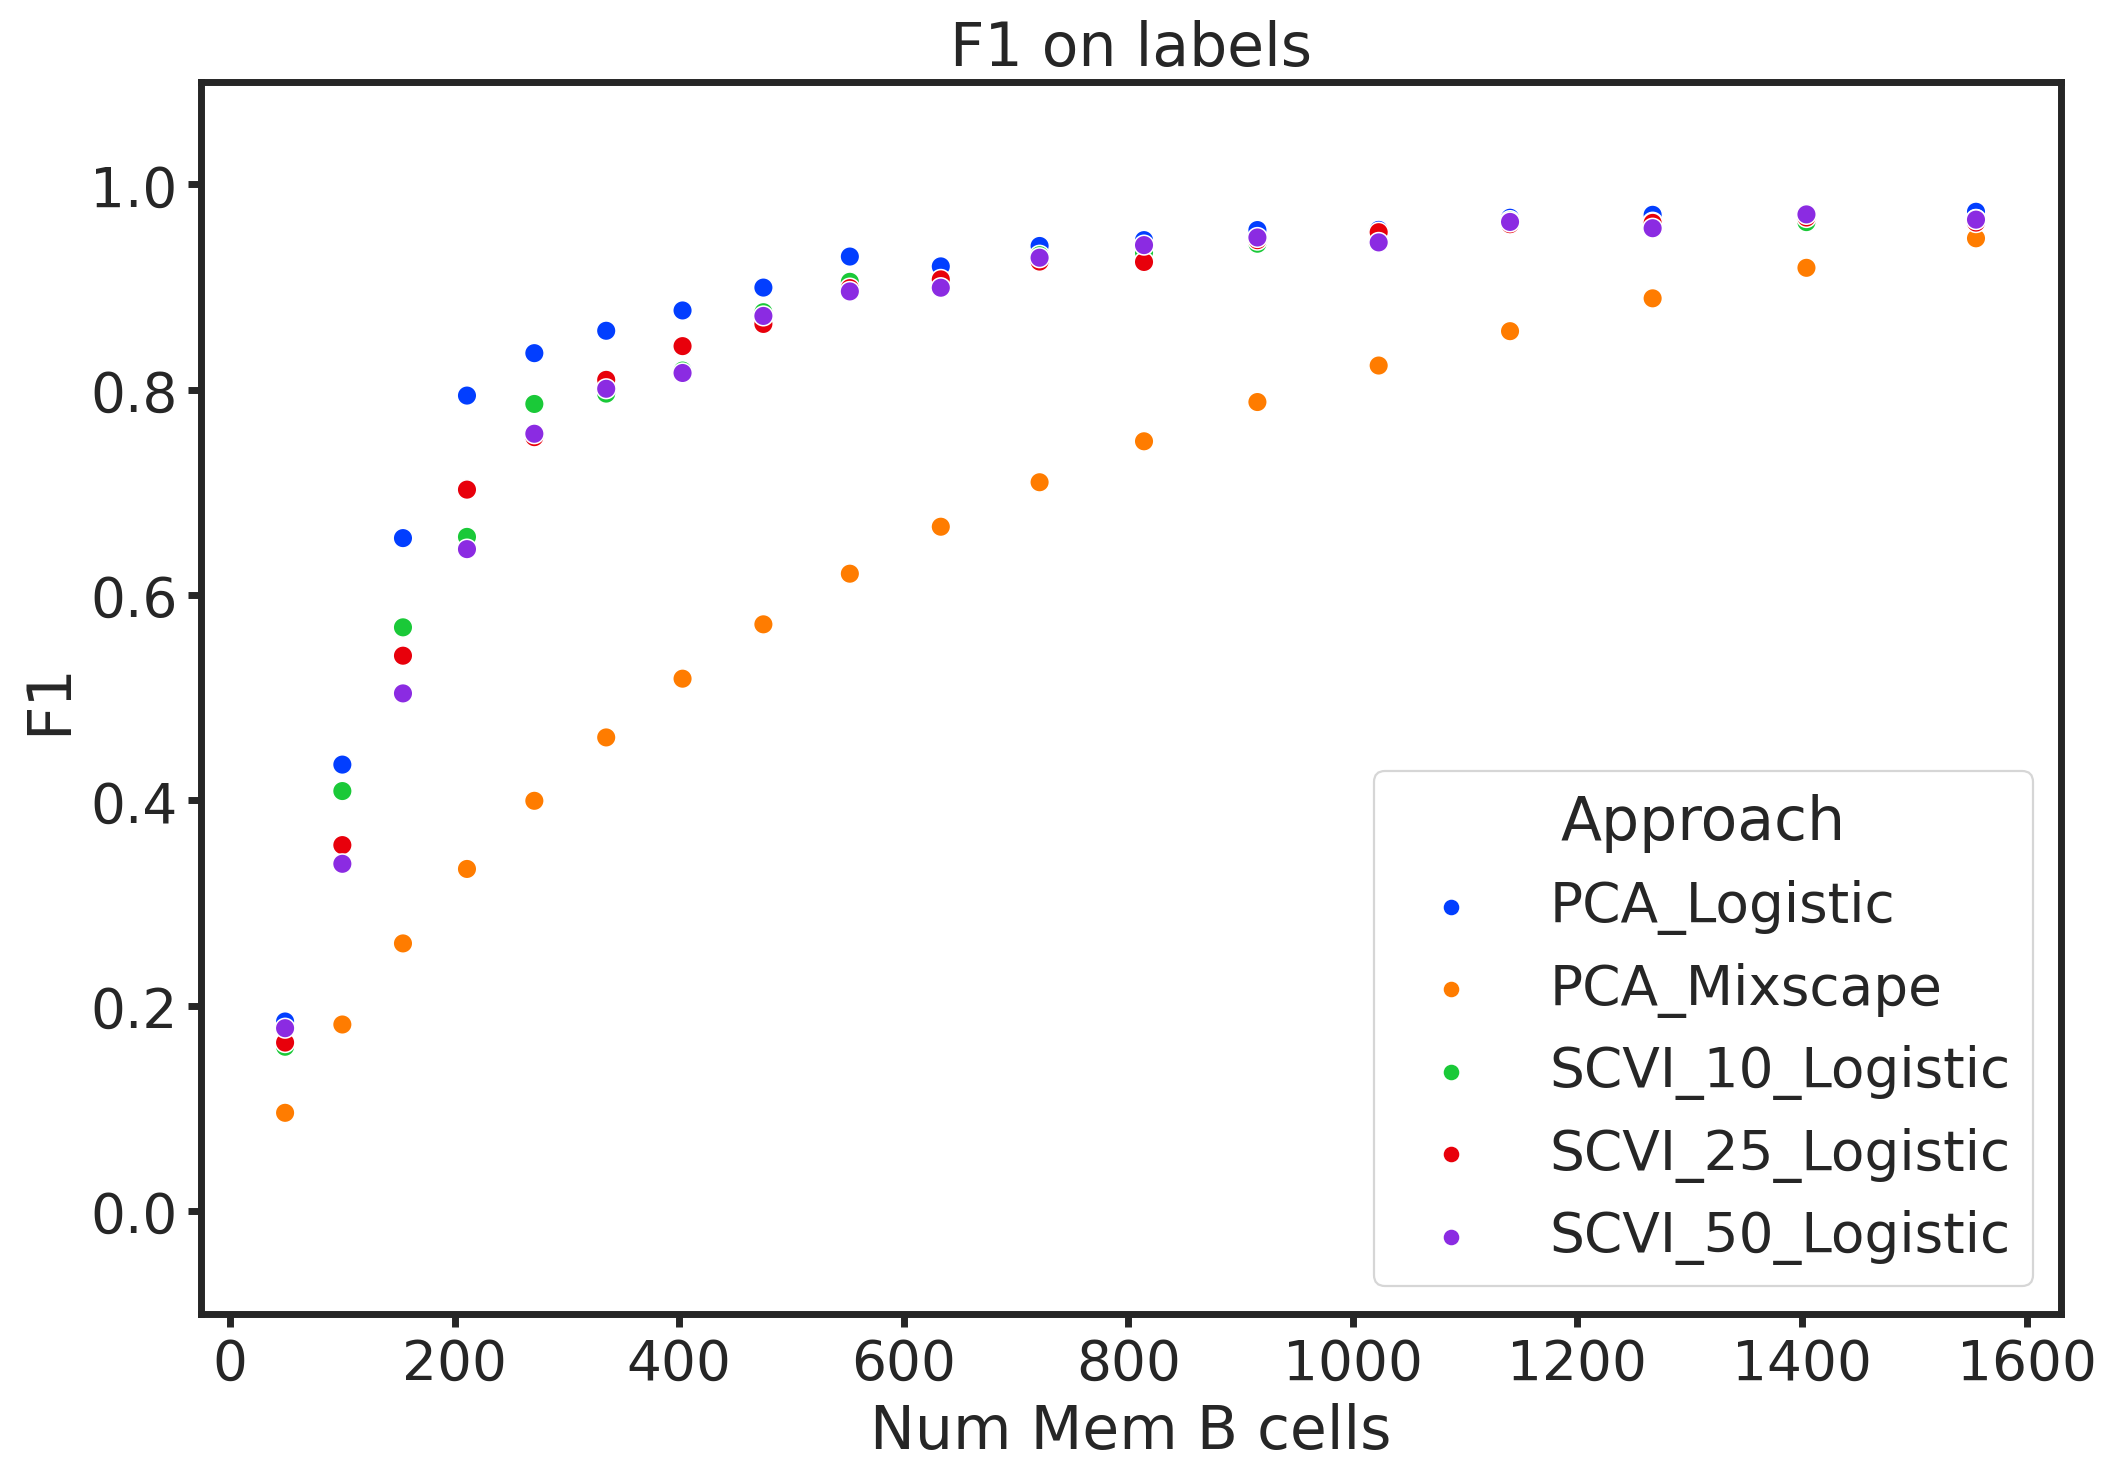

In [4]:
for metric in ['AUCROC', 'AP', 'Recall', 'Precision', 'F1']:
    methods = ['PCA_Logistic', 'PCA_Mixscape', 'SCVI_10_Logistic', 'SCVI_25_Logistic', 'SCVI_50_Logistic']
    vis_df = all_performance_df
    vis_df['Num Mem B cells'] = vis_df['Dataset'].apply(lambda x: int(x.split('_')[-1]))
    vis_df['Approach'] = vis_df['DimReduction']+'_'+vis_df['PredictionMethod']
    mask = vis_df['Approach'].isin(list(methods))
    vis_df = vis_df[mask]
    sns.scatterplot(x='Num Mem B cells', y=metric, hue='Approach', data=vis_df, s=50)
    plt.title(f'{metric} on labels')
    plt.ylim([-0.1, 1.1])
    plt.show()

In [ ]:
all_degenes_df

,Dataset,True labels,DimReduction,PredictionMethod,Approach,Precision,Recall,FDR,F1
0,naiveB_1900_memoryB_49,Naive B/Memory B,NaN,NaN,sample,NaN,0.000,NaN,NaN
1,naiveB_1900_memoryB_49,Naive B/Memory B,LinearSCVI_10,Logistic,LinearSCVI_10_Logistic,0.357,0.714,0.643,0.476
2,naiveB_1900_memoryB_49,Naive B/Memory B,LinearSCVI_10,SVM,LinearSCVI_10_SVM,0.200,0.214,0.800,0.207
3,naiveB_1900_memoryB_49,Naive B/Memory B,LinearSCVI_25,Logistic,LinearSCVI_25_Logistic,0.643,0.643,0.357,0.643
4,naiveB_1900_memoryB_49,Naive B/Memory B,LinearSCVI_25,SVM,LinearSCVI_25_SVM,0.600,0.429,0.400,0.500
...,...,...,...,...,...,...,...,...,...
10,naiveB_1900_memoryB_1555,Naive B/Memory B,SCVI_10,SVM,SCVI_10_SVM,0.917,0.972,0.083,0.944
11,naiveB_1900_memoryB_1555,Naive B/Memory B,SCVI_25,Logistic,SCVI_25_Logistic,0.914,0.962,0.086,0.938
12,naiveB_1900_memoryB_1555,Naive B/Memory B,SCVI_25,SVM,SCVI_25_SVM,0.904,0.960,0.096,0.931
13,naiveB_1900_memoryB_1555,Naive B/Memory B,SCVI_50,Logistic,SCVI_50_Logistic,0.916,0.956,0.084,0.935


## Performance on DE genes

,Dataset,True labels,DimReduction,PredictionMethod,Approach,Precision,Recall,FDR,F1,Num Mem B cells
7,naiveB_1900_memoryB_49,Naive B/Memory B,PCA,Logistic,PCA_Logistic,0.364,0.286,0.636,0.320,49
10,naiveB_1900_memoryB_49,Naive B/Memory B,SCVI_10,Logistic,SCVI_10_Logistic,0.429,0.214,0.571,0.286,49
12,naiveB_1900_memoryB_49,Naive B/Memory B,SCVI_25,Logistic,SCVI_25_Logistic,0.800,0.286,0.200,0.421,49
14,naiveB_1900_memoryB_49,Naive B/Memory B,SCVI_50,Logistic,SCVI_50_Logistic,0.000,0.000,1.000,NaN,49
7,naiveB_1900_memoryB_100,Naive B/Memory B,PCA,Logistic,PCA_Logistic,0.735,0.490,0.265,0.588,100
...,...,...,...,...,...,...,...,...,...,...
13,naiveB_1900_memoryB_1404,Naive B/Memory B,SCVI_50,Logistic,SCVI_50_Logistic,0.939,0.976,0.061,0.957,1404
7,naiveB_1900_memoryB_1555,Naive B/Memory B,PCA,Logistic,PCA_Logistic,0.936,0.966,0.064,0.951,1555
9,naiveB_1900_memoryB_1555,Naive B/Memory B,SCVI_10,Logistic,SCVI_10_Logistic,0.925,0.956,0.075,0.940,1555
11,naiveB_1900_memoryB_1555,Naive B/Memory B,SCVI_25,Logistic,SCVI_25_Logistic,0.914,0.962,0.086,0.938,1555


In [35]:
all_degenes_df['Num Mem B cells'].unique()

array([  49,  100,  154,  211,  271,  335,  403,  475,  552,  633,  721,
        814,  915, 1023, 1140, 1267, 1404, 1555])

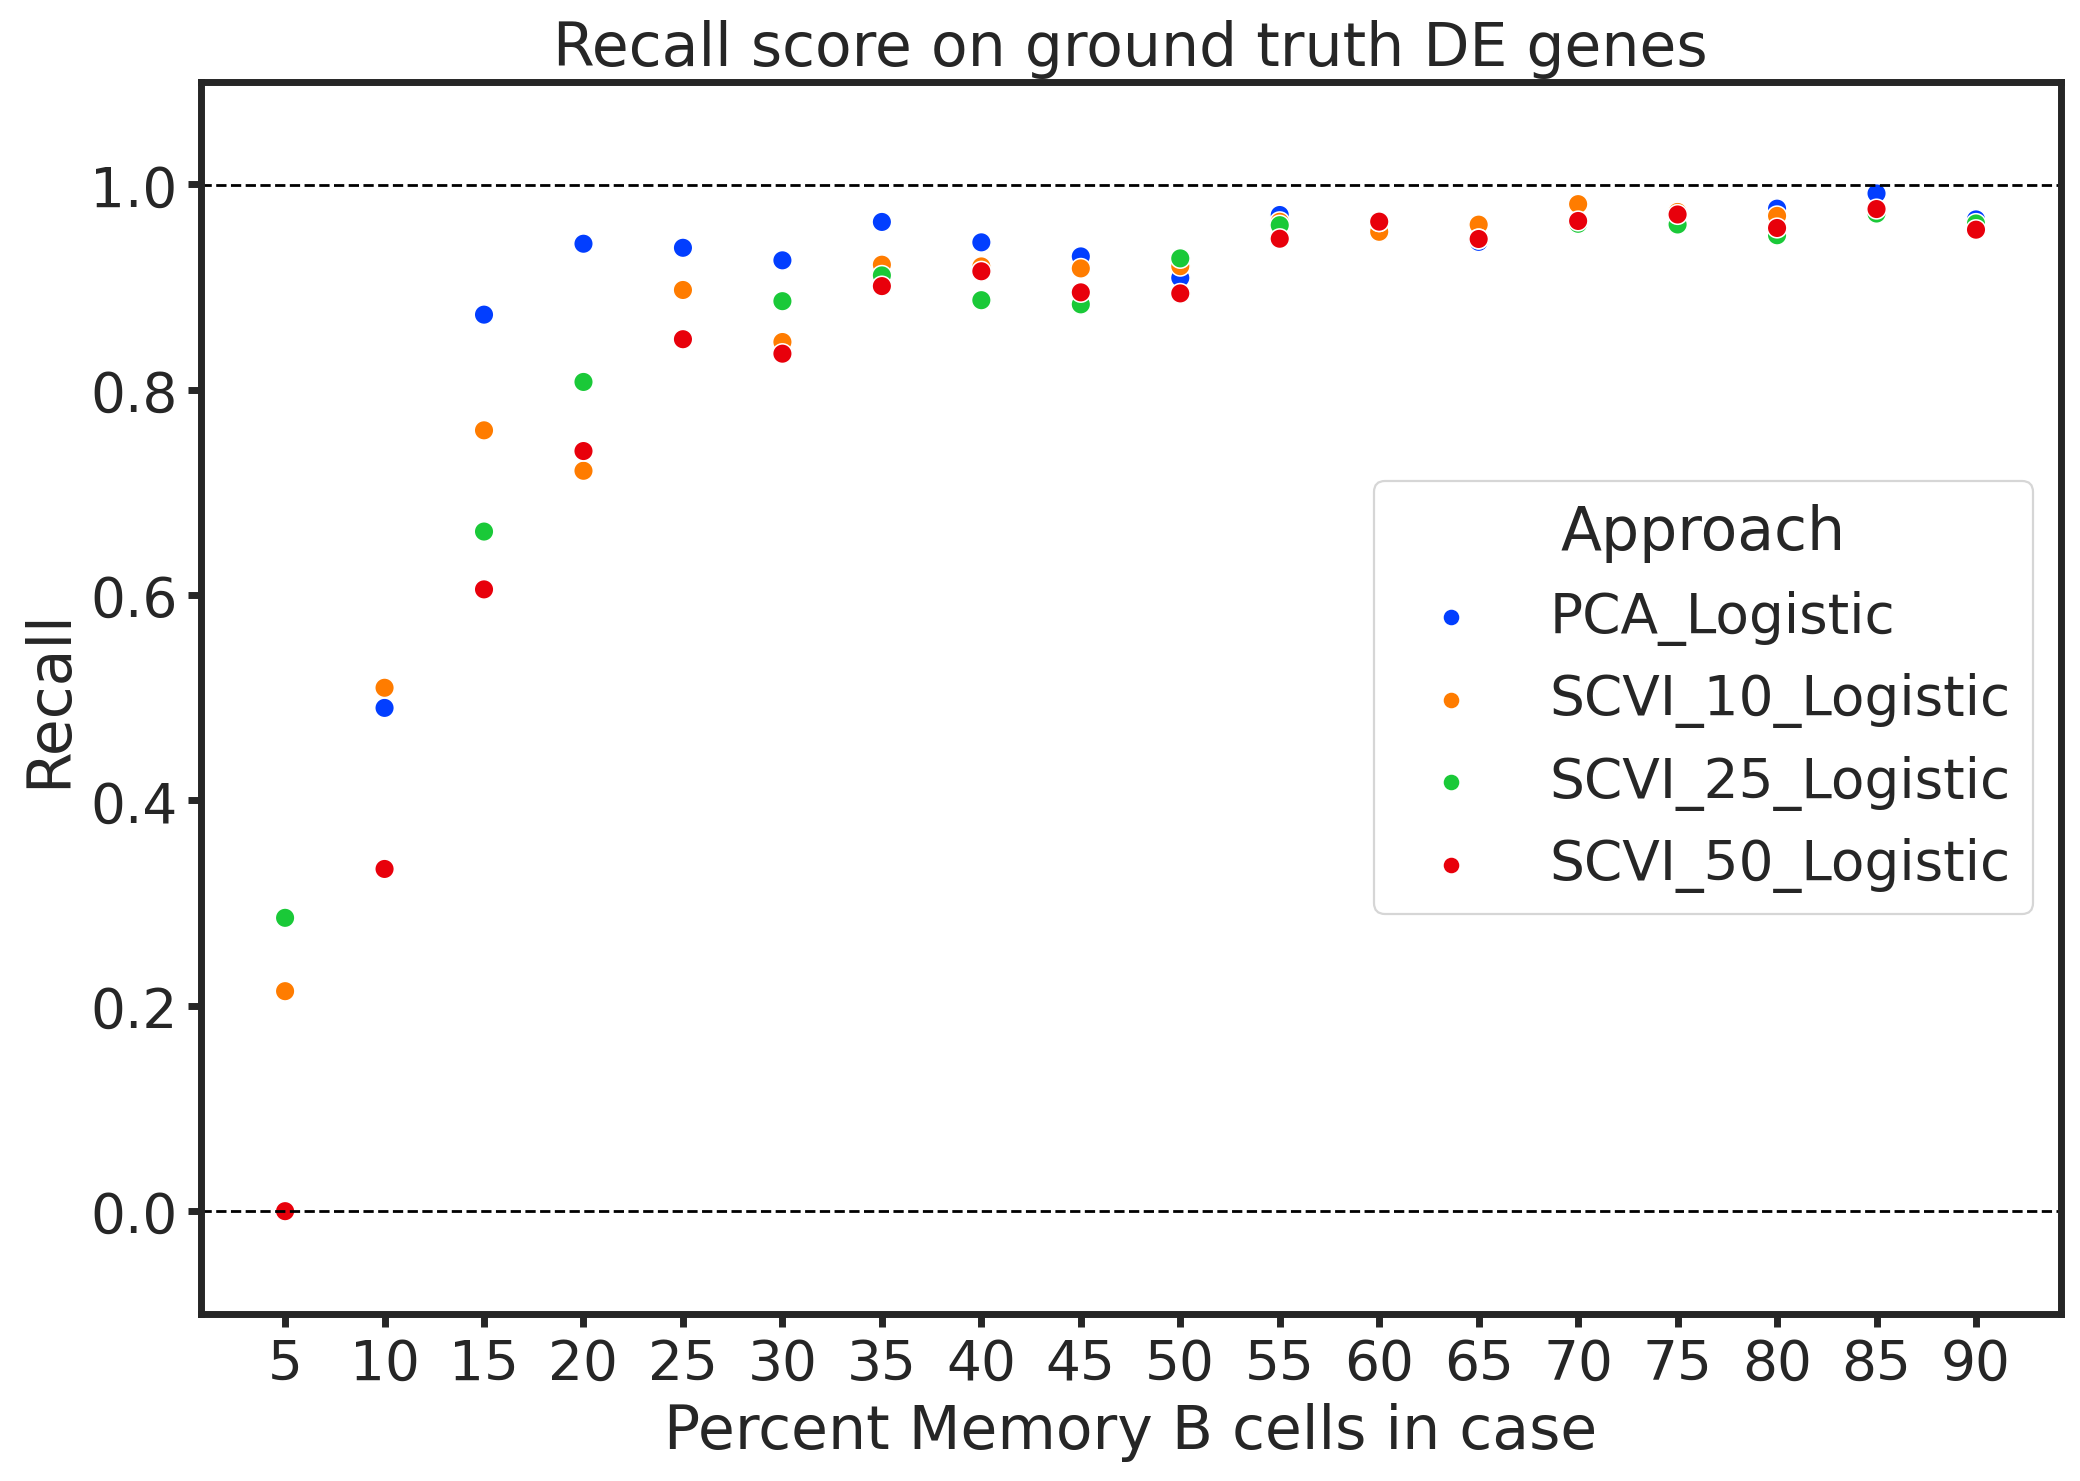

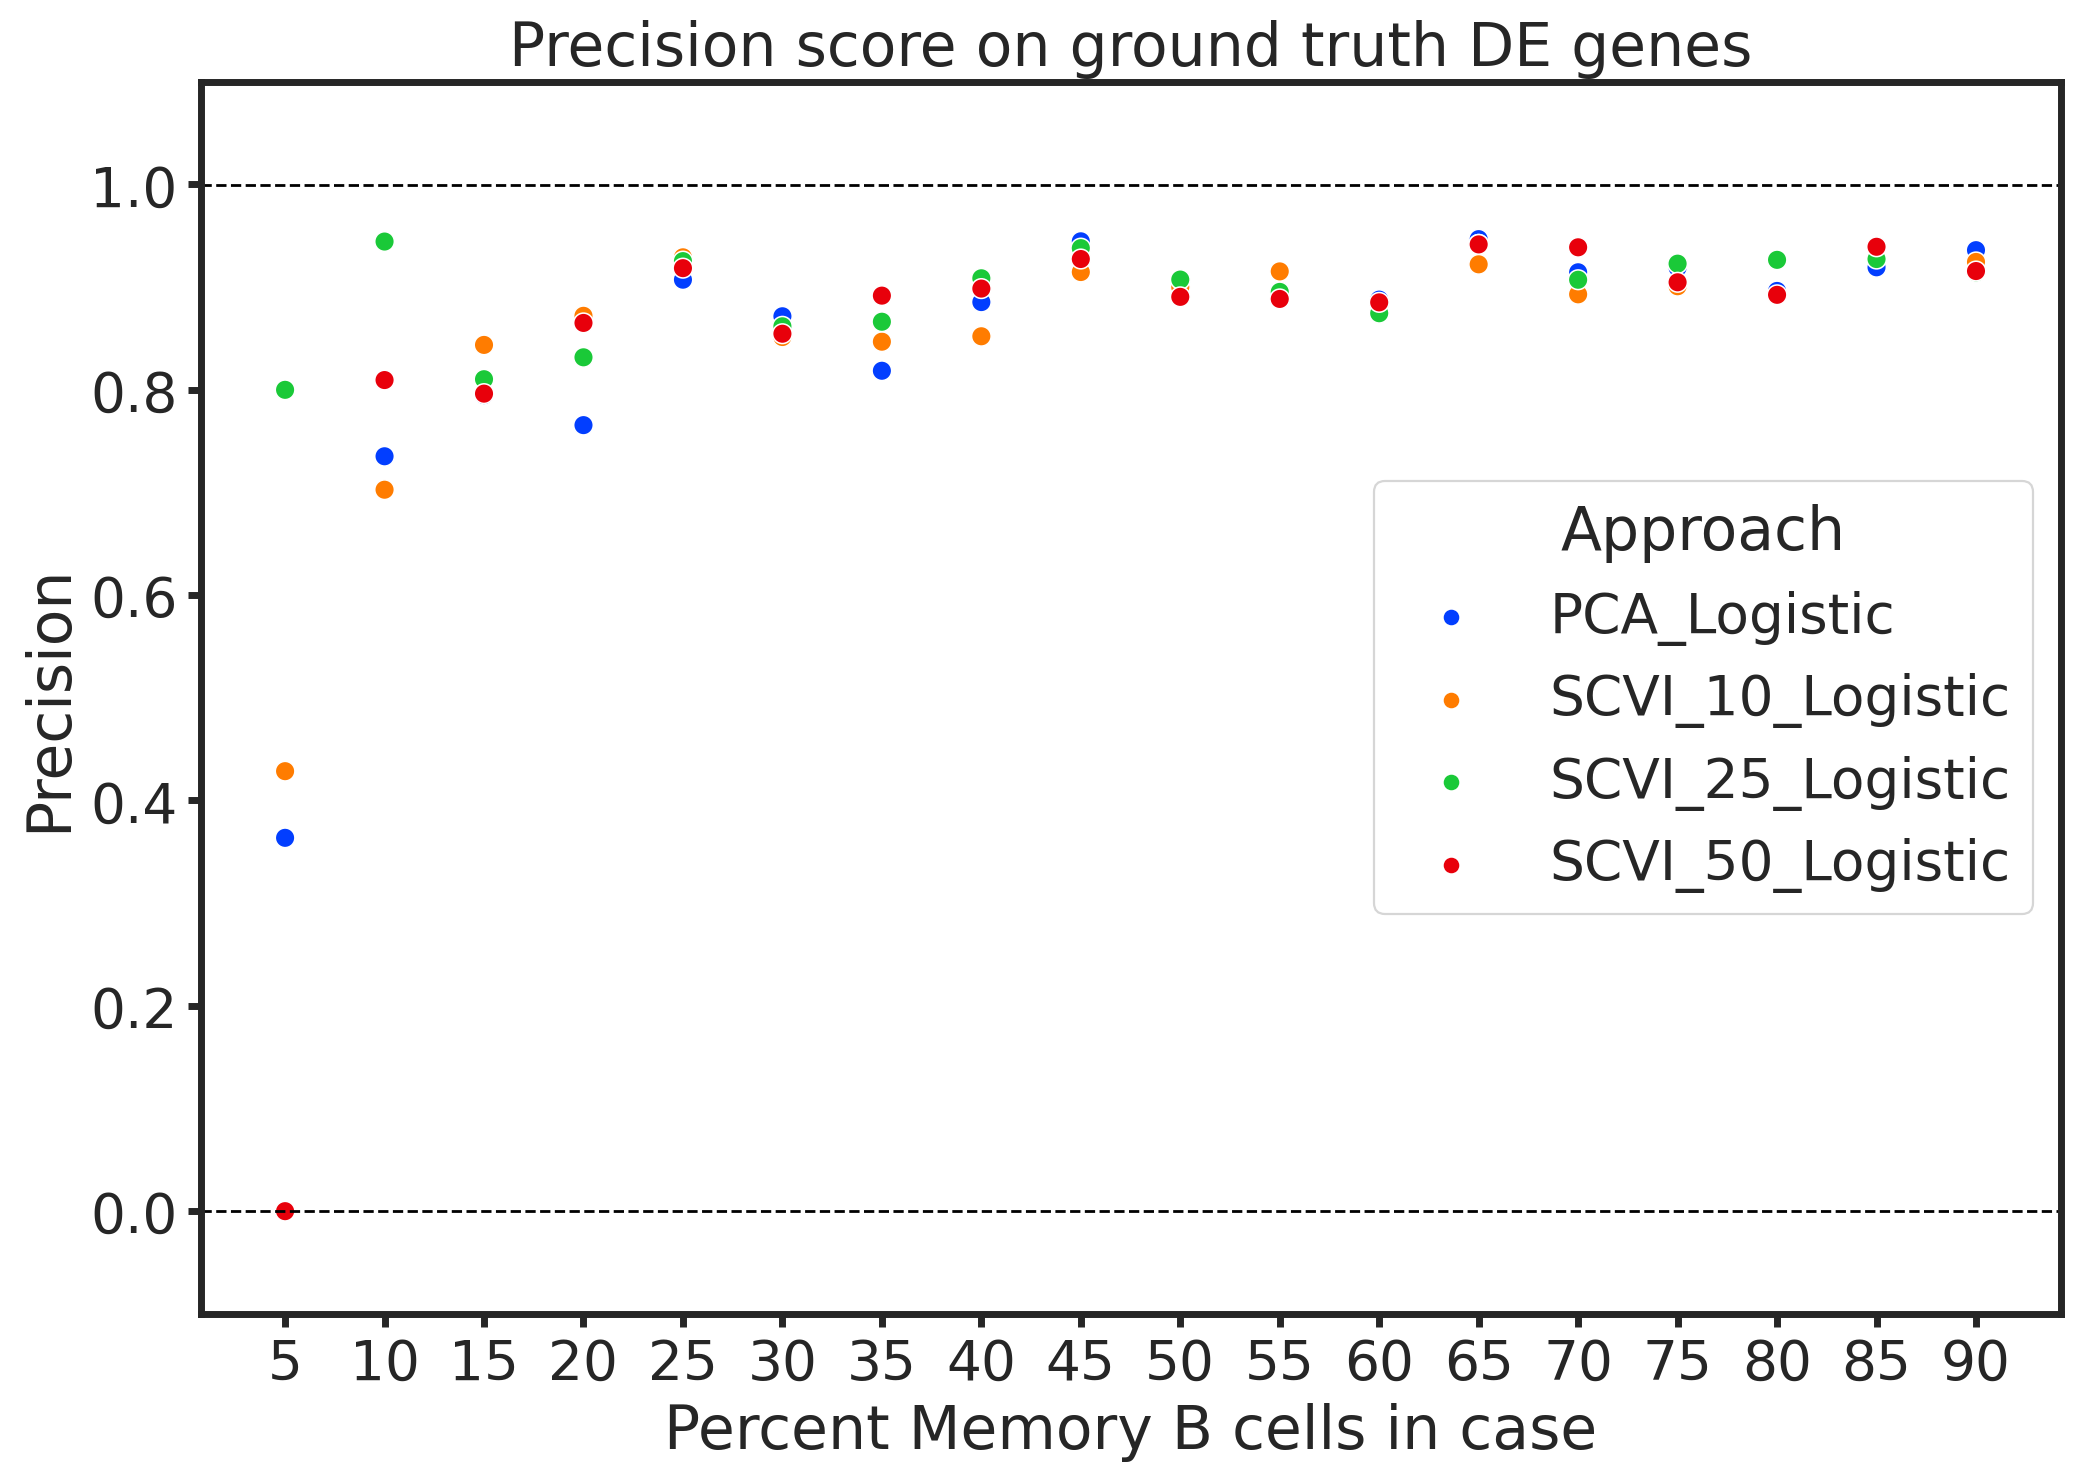

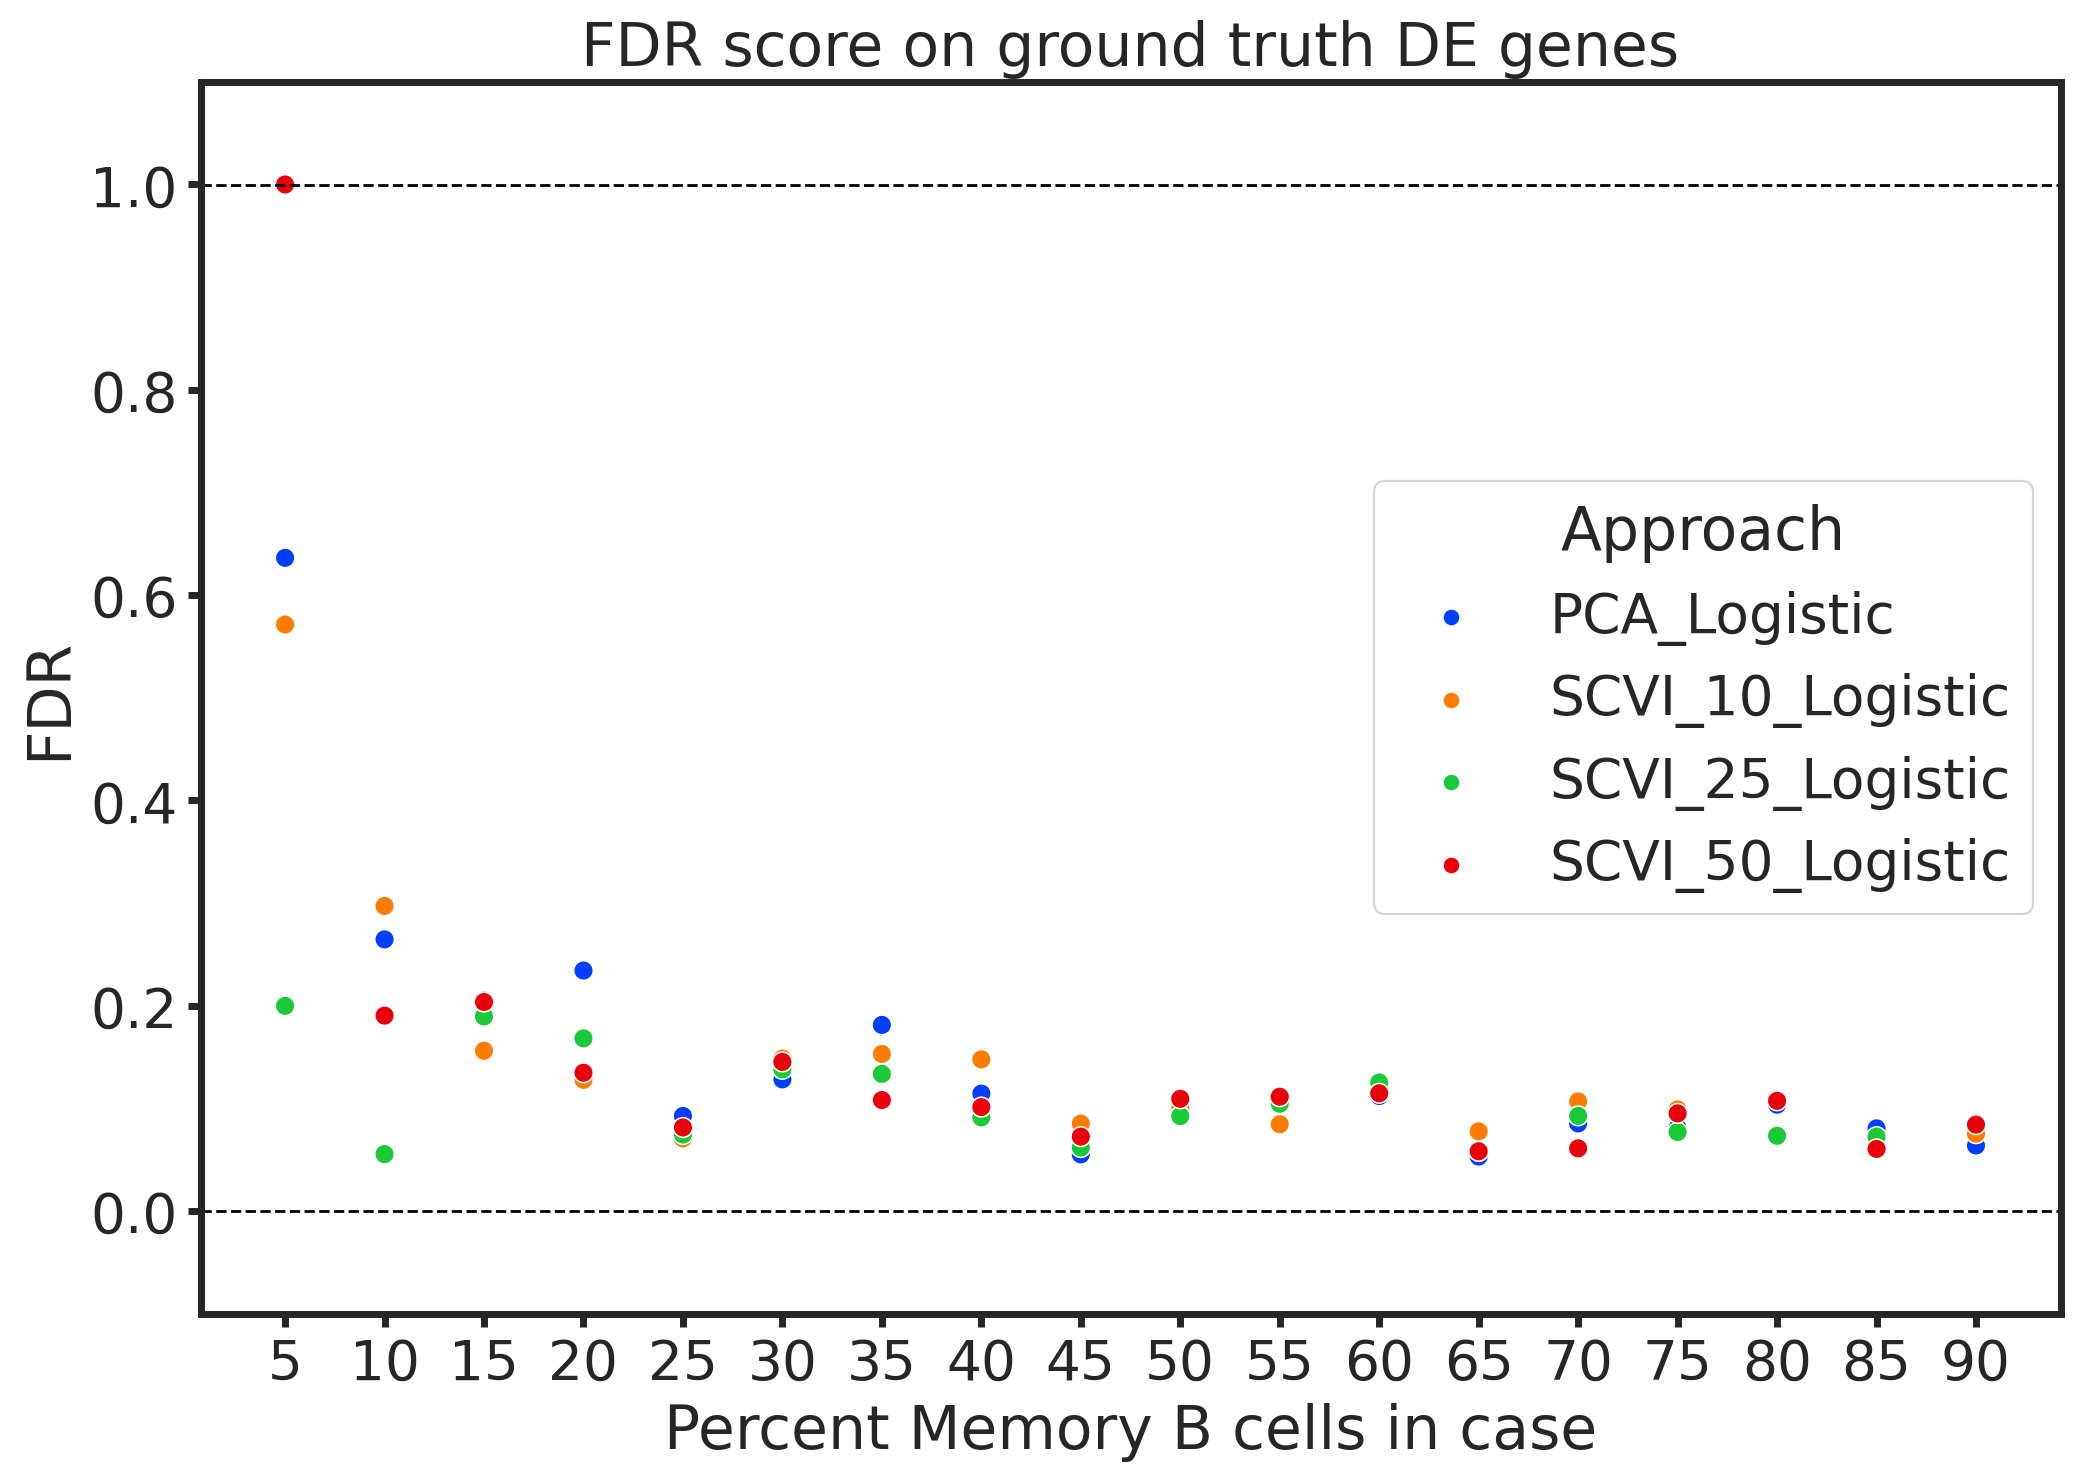

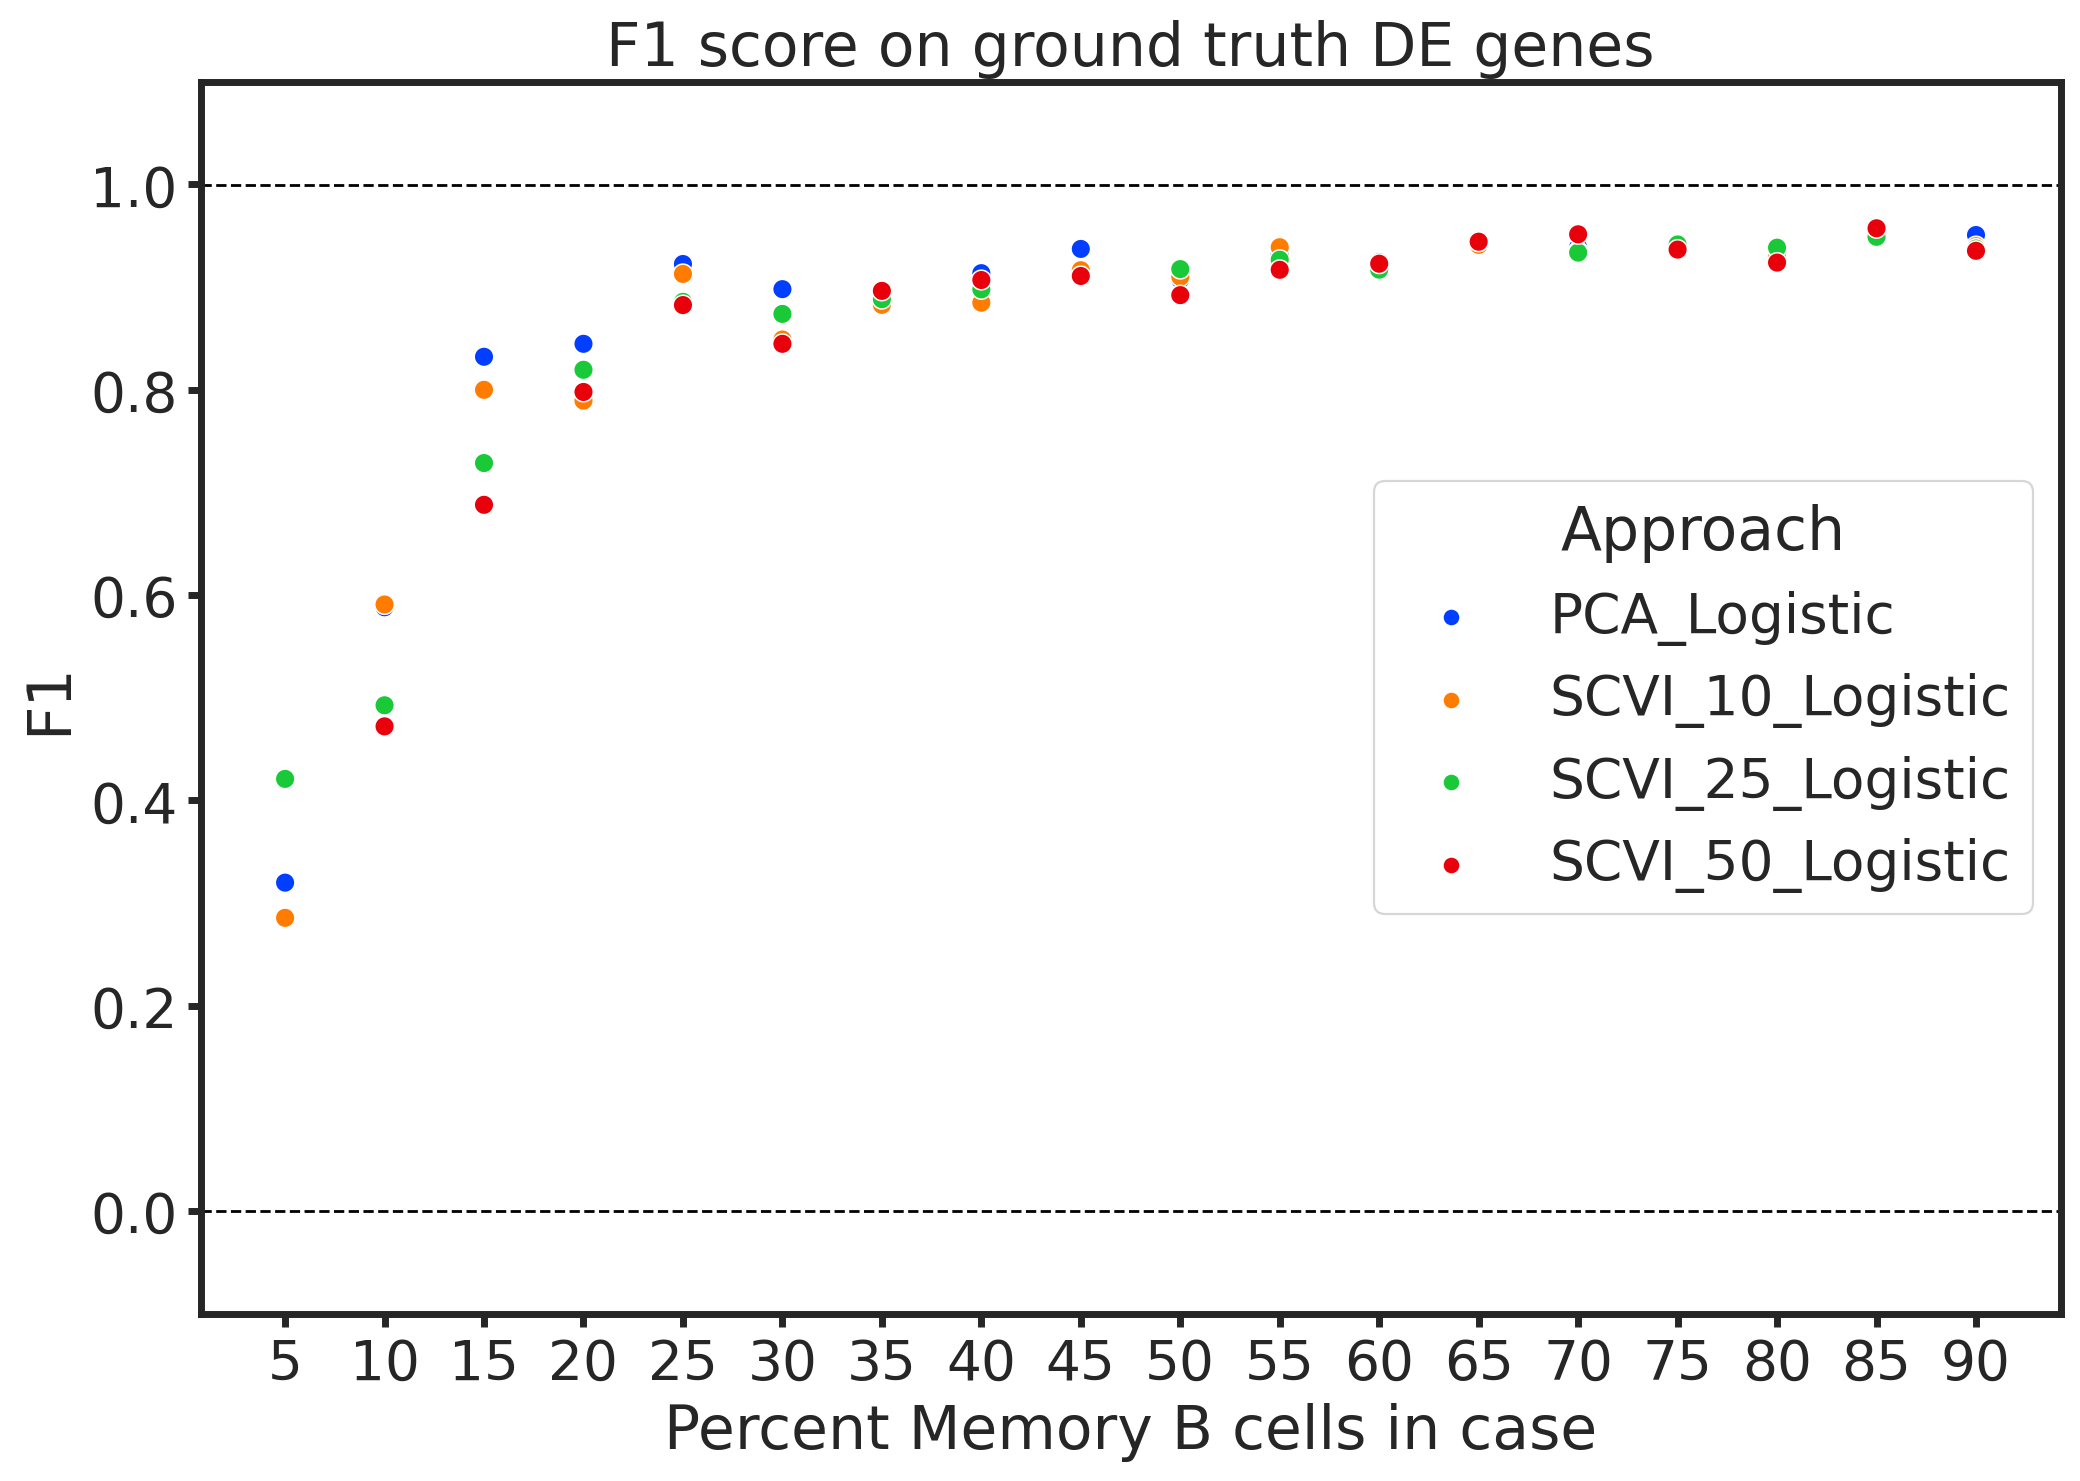

In [40]:
percent_map = dict(zip([  49,  100,  154,  211,  271,  335,  403,  475,  552,  633,  721,
        814,  915, 1023, 1140, 1267, 1404, 1555],
         [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90]))
                  
for metric in ['Recall', 'Precision', 'FDR', 'F1']:
    #methods = ['PCA_Logistic', 'PCA_Mixscape', 'SCVI_10_Logistic', 'SCVI_25_Logistic', 'SCVI_50_Logistic']
    methods = ['PCA_Logistic', 'SCVI_10_Logistic', 'SCVI_25_Logistic', 'SCVI_50_Logistic']
    vis_df = all_degenes_df
    vis_df['Num Mem B cells'] = vis_df['Dataset'].apply(lambda x: int(x.split('_')[-1]))
    vis_df['Percent Memory B cells in case'] = vis_df['Num Mem B cells'].apply(lambda x: percent_map[x])
    vis_df['Approach'] = vis_df['DimReduction']+'_'+vis_df['PredictionMethod']
    mask = vis_df['Approach'].isin(list(methods))
    vis_df = vis_df[mask]
    sns.scatterplot(x='Percent Memory B cells in case', y=metric, hue='Approach', data=vis_df, s=50)
    plt.title(f'{metric} score on ground truth DE genes')
    plt.ylim([-0.1, 1.1])
    plt.axhline(y = 0.0, color = 'k', linestyle = '--', linewidth=1)
    plt.axhline(y = 1.0, color = 'k', linestyle = '--', linewidth=1)
    plt.xticks(list(percent_map.values()))
    plt.show()